[View in Colaboratory](https://colab.research.google.com/github/orico/ActiveLearningFrameworkTutorial/blob/master/Active_Learning_Tutorial.ipynb)

## **Active Learning Tutorial**

These days we are exposed to an abundance of unlabeled data either from the Internet or from some other source such as academia or business worlds. Due to the fact that unlabeled data is relatively easy to acquire and is expensive to label, companies usually employ an expert or several employees whose purpose is to label data [1]. Consider the following situation, a data-driven medical company has a lot of MRI scans and they need to employ an expert that will help them interpret these scans. The company has limited resources and they cant interpret or label all of their data; this is the point where they decide to use active-learning (AL). The promise of AL is that by iteratively increasing the size of our carefully selected labeled data, it is possible to achieve similar (or greater [2]) performance to using a fully supervised data-set with a fraction of the cost or time that it takes to label all the data. AL is considered to be a semi-supervised method, between unsupervised and fully supervised in terms of the amount of labeled data, i.e., for unsupervised data we use 0% labeled samples and for fully supervised we use 100% labeled samples. Therefore, the decision of how much data to use or alternatively how much performance is required from the model relies on a resource management decision, in other words it can be a business decision. 

There are three scenarios for AL: 
1. Membership Query Synthesis, i.e., a generated sample is sent to an oracle for labeling.
2. Stream-Based Selective Sampling, i.e, each sample is considered separately for labeling or rejection.
3. Pool-Based sampling, i.e., sampled are chosen from a pool of unlabeled data for the purpose of labeling [3]. 
In this tutorial we use the third scenario.

The following pseudo algorithm represents the learning process, as written in the code, for pool-based sampling:
1. Divide the data to a 'pool' and a test-set
2. Select 'k' samples from the pool for the initial train-set and label them, the remaining data will be the validation-set
3. Normalize all the sets
4. Train the Model using the train-set, with balanced weights.
5. Use the trained model with the validation-set, get probabilities per sample.
6. Use the trained model with the test-set, get performance measures.
7. Select 'k' most-informative samples based on per-sample-probabilities, i.e., those that the model was most uncertain about regarding their labelling.
8. Move these 'k' samples from the validation set to the train-set and query their labels.
9. Inverse normalization for all the data-sets
10. Stop according to the stop criterion, otherwise go to 3. 

There are a few things to note before going forward: 
1. The fully-supervised performance of a chosen algorithm is usually the upper bound, therefore it is advisable to try several algorithms.
2. Normalization for all sets must be inversed and normalized again after we remove samples from the validation set, because our sample distribution changed in both the new validation and new train-sets.
2. The sample selection function relies on test-sample probabilities derived from the trained model, therefore we can only use algorithms that provide access to sample probabilities.
3. 'k' is a hyper parameter

Our most important tool in AL method is the sample selection function, this is the only point where we influence the learning process and it crucial to use the right method. This area is a hot research topic and there are many studies that propose competing selection functions. 
In this tutorial I propose four known selection functions:
1. Random selection - we select 'k' random samples from the validation set.
2. Entropy selection - we select 'k' samples with the highest entropy, i.e., with high uncertainty.
3. Margin selection - we select 'k' samples with the lowest difference between the two highest class probabilities, i.e., a higher figure will be given for samples whose model was very certain about a single class and lower to samples whose class probabilities are very similar. 

The code provided [here](https://drive.google.com/file/d/112qNUli8PHh66Tnc9sHrv7fGLDdD3Ri4/view?usp=sharing) utilizes a modular architecture in terms of selecting various learning algorithms and selection functions and can be used as a base for other model-function comparisons.

We compare several learning algorithms, such as support vector machine (SVM) with a linear kernel, random forest (RF) and logistic regression (LOG). Each algorithm was executed with all of the selection functions using all 'k' = [10,25,50,125,250], accumulating a total of 80 experiments. Due to the random nature of some of the algorithms and the selection functions, it is advisable to run repeated experiments in the code in order to calculate a statistical significant result. However, running times are long and I have chosen to run the experiment only once for each combination of (model,function,k).

The following is an explanation of the code and its class architecture.


We start with all the needed dependencies.

In [0]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from pylab import rcParams
from sklearn.utils import check_random_state
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, \
    GradientBoostingClassifier

max_queried = 500

We start by downloading our data and splitting it to train and test, according to known MNIST definitions 60K/10K split. later the train-set will be split to train and validation.


In [0]:
trainset_size = 60000  # ie., testset_size = 10000

def download():
    mnist = fetch_mldata('MNIST original')
    X = mnist.data.astype('float64')
    y = mnist.target
    print ('MNIST:', X.shape, y.shape)
    return (X, y)


def split(train_size):
    X_train_full = X[:train_size]
    y_train_full = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    return (X_train_full, y_train_full, X_test, y_test)


We create a modular class representation, 'BaseModel' is a base model for the class architecture, you can implement new models and use them interchangeably or in addition to all other models.
our current implementations include SVM, logistic regression, random forest and gradient boosting.

In [0]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(C=1, kernel='linear', probability=True,
                              class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class LogModel(BaseModel):

    model_type = 'Multinominal Logistic Regression' 
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training multinomial logistic regression')
        train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight=c_weight,
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)
   

Our 'TrainModel' class accepts one of the previously in defined learning algorithms, trains using the training set and gets performance measurements from the test set.

In [0]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and get probabilities for the validation set. i.e., we use the probabilities to select the most uncertain samples

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape, 'y:', y_train.shape)
        print ('Val   set:', X_val.shape)
        print ('Test  set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)  # we return them in case we use PCA, with all the other algorithms, this is not needed.

    # we want accuracy only for the test set

    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print('Example run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate for %f " % (classif_rate))    
        print("Classification report for classifier %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')


We create a modular selection function class representation, 'BaseSelectionFunction' is a base class for various sample selection methods. Using this architecture, you can implement new selection methods and use them in addition or instead of previous methods, for experimental purposes. Our current implementations include random-selection, entropy-selection, margin sampling-selection and minimum standard deviation-selection.

In [0]:
class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)

#     print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',initial_labeled_samples)

        return selection


class EntropySelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
        return selection
      
      
class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection


We have a class that is used to normalize using a MinMax Scaler in the range of [0,1].

In [0]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

Initially we would like to get a random sampling from the unlabeled data-pool, this is done using random.choice without replacement.

In [0]:
def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size,
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape),
#            permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64'))
    unique = np.unique(y_train.astype('int64'))
    print (
        'initial train set:',
        X_train.shape,
        y_train.shape,
        'unique(labels):',
        bin_count,
        unique,
        )
    return (permutation, X_train, y_train)

This is the main class that initiates the active-learning process according to the algorithm described in the introduction. In short, we select 'k' random samples, train a model, select the most informative samples, remove from the validation set, query their labels and retrain using those samples until reaching the stop criteria.

In [0]:
class TheAlgorithm(object):

    accuracies = []

    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test):

        # initialize process by applying base learner to labeled training data set to obtain Classifier

        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full)
        self.queried = self.initial_labeled_samples
        self.samplecount = [self.initial_labeled_samples]

        # permutation, X_train, y_train = get_equally_k_random_samples(self.initial_labeled_samples,classes)

        # assign the val set the rest of the 'unlabelled' training data

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        print ('val set:', X_val.shape, y_val.shape, permutation.shape)
        print ()

        # normalize data

        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)   
        
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        # fpfn = self.clf_model.test_y_predicted.ravel() != y_val.ravel()
        # print(fpfn)
        # self.fpfncount = []
        # self.fpfncount.append(fpfn.sum() / y_test.shape[0] * 100)

        while self.queried < max_queried:

            active_iteration += 1

            # get validation probabilities

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            print ('val predicted:',
                   self.clf_model.val_y_predicted.shape,
                   self.clf_model.val_y_predicted)
            print ('probabilities:', probas_val.shape, '\n',
                   np.argmax(probas_val, axis=1))

            # select samples using a selection function

            uncertain_samples = \
                self.sample_selection_function.select(probas_val, self.initial_labeled_samples)

            # normalization needs to be inversed and recalculated based on the new train and test set.
 
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set

            print ('trainset before', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print ('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            unique = np.unique(y_train.astype('int64'))
            print (
                'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
                )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print ('val set:', X_val.shape, y_val.shape)
            print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        print ('final active learning accuracies',
               self.clf_model.accuracies)





We download the data, split to train validation and test, we run the experiment by iterating over all of our training algorithms X all of our selection functions X all possible k's in the range of [10,25,50,125,250]. The accuracy results are kept in a dictionary and pickle-saved to a unique file as soon as the model finishes training - this is crucial when using google colaboratory as it tends to disconnect from time to time. We also limit our training to a maximum of 500 queried samples.

In [0]:
(X, y) = download()
(X_train_full, y_train_full, X_test, y_test) = split(trainset_size)
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)

def pickle_save(fname, data):
  filehandler = open(fname,"wb")
  pickle.dump(data,filehandler)
  filehandler.close() 
  print('saved', fname, os.getcwd(), os.listdir())

def pickle_load(fname):
  print(os.getcwd(), os.listdir())
  file = open(fname,'rb')
  data = pickle.load(file)
  file.close()
  print(data)
  return data
  
def experiment(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test)
                    d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                    fname = 'Active-learning-experiment-' + str(count) + '.pkl'
                    pickle_save(fname, d)
                    if count % 5 == 0:
                        print(json.dumps(d, indent=2, sort_keys=True))
                    print ()
                    print ('---------------------------- FINISHED ---------------------------')
                    print ()
    return d


max_queried = 500 

repeats = 1

models = [SvmModel, RfModel, LogModel] 

selection_functions = [RandomSelection, MarginSamplingSelection, EntropySelection] 

Ks = [250,125,50,25,10] 

d = {}
stopped_at = -1 

# print('directory dump including pickle files:', os.getcwd(), np.sort(os.listdir()))  
# d = pickle_load('Active-learning-experiment-' + str(stopped_at) + '.pkl')  
# print(json.dumps(d, indent=2, sort_keys=True))

d = experiment(d, models, selection_functions, Ks, repeats, stopped_at+1)
print (d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
print(results)


Independently, we trained several models using a train-test split of 60K-10K, the results indicate that the upper-bound for RF, SVM and LOG are 97., 94. and 92.47, respectively.

The following graphs show that the random forest classifier paired with the margin-selection method and k=10 is the best configuration.

So which is the better model? under the stopping condition and hyper parameters - random forest is the winner!


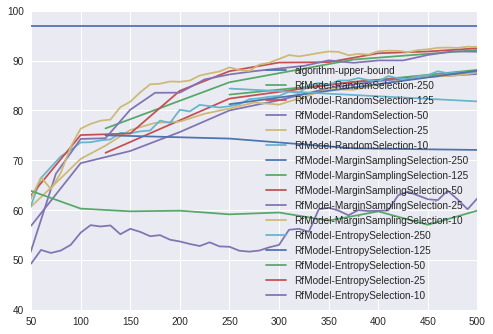

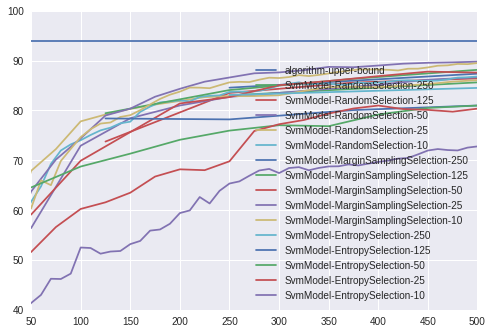

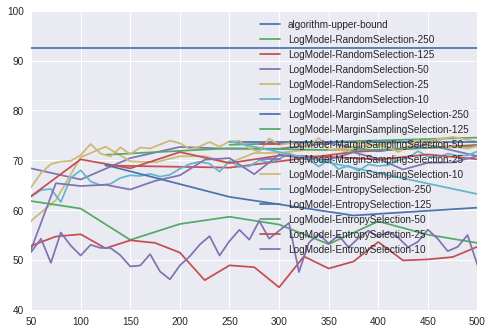

In [64]:
def performance_plot(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats):  
    fig, ax = plt.subplots()
    ax.plot([0,500],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    for model_object in models:
      for selection_function in selection_functions:
        for idx, k in enumerate(Ks):
            x = np.arange(float(Ks[idx]), 500 + float(Ks[idx]), float(Ks[idx]))            
            Sum = np.array(dic[model_object][selection_function][k][0])
            for i in range(1, repeats):
                Sum = Sum + np.array(dic[model_object][selection_function][k][i])
            mean = Sum / repeats
            ax.plot(x, mean ,label = model_object + '-' + selection_function + '-' + str(k))
    ax.legend()
    ax.set_xlim([50,500])
    ax.set_ylim([40,100])
    ax.grid(True)
    plt.show()

models_str = ['SvmModel', 'RfModel', 'LogModel']
selection_functions_str = ['RandomSelection', 'MarginSamplingSelection', 'EntropySelection']
Ks_str = ['250','125','50','25','10'] 
repeats = 1
random_forest_upper_bound = 97.
svm_upper_bound = 94.
log_upper_bound = 92.47
total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

print('So which is the better model? under the stopping condition and hyper parameters - random forest is the winner!')
performance_plot(random_forest_upper_bound, d, ['RfModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(svm_upper_bound, d, ['SvmModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(log_upper_bound, d, ['LogModel'] , selection_functions_str    , Ks_str, 1)



So which is the best sample selection function? margin sampling is the winner!


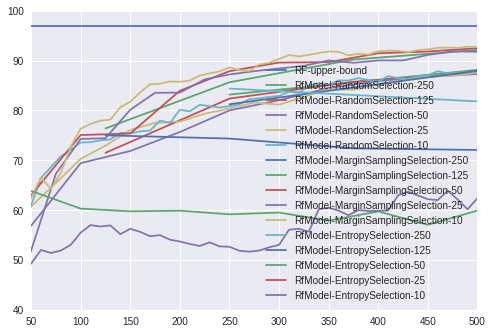


So which is the best k? k=10 is the winner


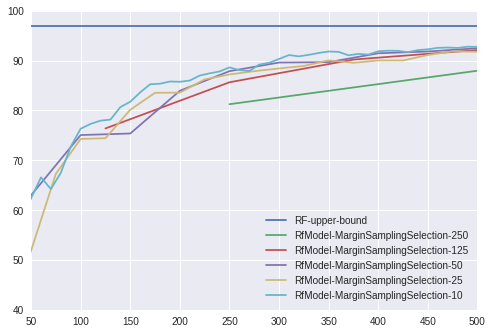

In [62]:

print('So which is the best sample selection function? margin sampling is the winner!')
performance_plot(random_forest_upper_bound, d, ['RfModel'], selection_functions_str    , Ks_str, 1)
print()
print('So which is the best k? k=10 is the winner')
performance_plot(random_forest_upper_bound, d, ['RfModel'] , ['MarginSamplingSelection'], Ks_str, 1)



Ori Cohen has done his PhD in computer science in the fields of machine learning, brain-computer-interface and neurobiology.

[1] Shay Yehezkel, *High Dimensional Statistical Process Control and Application*, M.Sc Thesis.

[2] Ilhan, Hamza Osman, and Mehmet Fatih Amasyali. "[*Active Learning as a Way of Increasing Accuracy*](http://www.ijcte.org/papers/910-AC0013.pdf)." International Journal of Computer Theory and Engineering 6, no. 6 (2014): 460.

[3] Stefan Hosein [*Active Learning: Curious AI Algorithms*](https://www.datacamp.com/community/tutorials/active-learning)


In [5]:
#@title Executed code for the experiment with output.
#!/usr/bin/python
# -*- coding: utf-8 -*-
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from pylab import rcParams
from sklearn.utils import check_random_state
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, \
    GradientBoostingClassifier

trainset_size = 60000  # ie., testset_size = 10000
max_queried = 500


# ==============================================================================

def download():
    mnist = fetch_mldata('MNIST original')
    X = mnist.data.astype('float64')
    y = mnist.target
    print ('MNIST:', X.shape, y.shape)
    return (X, y)


def split(train_size):
    X_train_full = X[:train_size]
    y_train_full = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    return (X_train_full, y_train_full, X_test, y_test)


# ==============================================================================

class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(C=1, kernel='linear', probability=True,
                              class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class GmmModel(BaseModel):

    model_type = 'Gaussian Mixture Model'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training gaussian mixture model...')
        pca = PCA(n_components=75).fit(X_train)  # ,whiten=True).fit(X_train)
        reduced_train_data = pca.transform(X_train)
        reduced_test_data = pca.transform(X_test)
        reduced_val_data = pca.transform(X_val)
        print ('PCA: explained_variance_ratio_',
               np.sum(pca.explained_variance_ratio_))
        self.classifier = GaussianMixture(n_components=10, covariance_type='full')
        self.classifier.fit(reduced_train_data)
        self.test_y_predicted = \
            self.classifier.predict(reduced_test_data)
        self.val_y_predicted = self.classifier.predict(reduced_val_data)
        return (reduced_train_data, reduced_val_data,
                reduced_test_data, self.val_y_predicted,
                self.test_y_predicted)


class LogModel(BaseModel):

    model_type = 'Multinominal Logistic Regression' 
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training multinomial logistic regression')
        train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight=c_weight,
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class GbcModel(BaseModel):

    model_type = 'Gradient Boosting Classifier'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training gradient boosting...')
        parm = {
            'n_estimators': 1200,
            'max_depth': 3,
            'subsample': 0.5,
            'learning_rate': 0.01,
            'min_samples_leaf': 1,
            'random_state': 3,
            }
        self.classifier = GradientBoostingClassifier(**parm)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)


# ====================================================================================================

class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and get probabilities for the validation set. i.e., we use the probabilities to select the most uncertain samples

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape, 'y:', y_train.shape)
        print ('Val   set:', X_val.shape)
        print ('Test  set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)  # we return them in case we use PCA, with all the other algorithms, this is not needed.

    # we want accuracy only for the test set

    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print('Example run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate for %f " % (classif_rate))    
        print("Classification report for classifier %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')


# ====================================================================================================

def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size,
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape),
#            permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64'))
    unique = np.unique(y_train.astype('int64'))
    print (
        'initial train set:',
        X_train.shape,
        y_train.shape,
        'unique(labels):',
        bin_count,
        unique,
        )
    return (permutation, X_train, y_train)


# ====================================================================================================

class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)

#     print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',initial_labeled_samples)

        return selection


class MinStdSelection(BaseSelectionFunction):

    # select the samples where the std is smallest - i.e., there is uncertainty regarding the relevant class
    # and then train on these "hard" to classify samples.

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        std = np.std(probas_val * 100, axis=1)
        selection = std.argsort()[:initial_labeled_samples]
        selection = selection.astype('int64')

#     print('std',std.shape,std)
#     print()
#     print('selection',selection, selection.shape, std[selection])

        return selection


class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection


class EntropySelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
        return selection


# ====================================================================================================

class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

      
# ====================================================================================================

class TheAlgorithm(object):

    accuracies = []

    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test):

        # initialize process by applying base learner to labeled training data set to obtain Classifier

        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full)
        self.queried = self.initial_labeled_samples
        self.samplecount = [self.initial_labeled_samples]

        # permutation, X_train, y_train = get_equally_k_random_samples(self.initial_labeled_samples,classes)

        # assign the val set the rest of the 'unlabelled' training data

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        print ('val set:', X_val.shape, y_val.shape, permutation.shape)
        print ()

        # normalize data

        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)   
        
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        # fpfn = self.clf_model.test_y_predicted.ravel() != y_val.ravel()
        # print(fpfn)
        # self.fpfncount = []
        # self.fpfncount.append(fpfn.sum() / y_test.shape[0] * 100)

        while self.queried < max_queried:

            active_iteration += 1

            # get validation probabilities

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            print ('val predicted:',
                   self.clf_model.val_y_predicted.shape,
                   self.clf_model.val_y_predicted)
            print ('probabilities:', probas_val.shape, '\n',
                   np.argmax(probas_val, axis=1))

            # select samples using a selection function

            uncertain_samples = \
                self.sample_selection_function.select(probas_val, self.initial_labeled_samples)

            # normalization needs to be inversed and recalculated based on the new train and test set.
 
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set

            print ('trainset before', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print ('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            unique = np.unique(y_train.astype('int64'))
            print (
                'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
                )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print ('val set:', X_val.shape, y_val.shape)
            print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        print ('final active learning accuracies',
               self.clf_model.accuracies)


# get MNIST

(X, y) = download()
(X_train_full, y_train_full, X_test, y_test) = split(trainset_size)
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)

def pickle_save(fname, data):
  filehandler = open(fname,"wb")
  pickle.dump(data,filehandler)
  filehandler.close() 
  print('saved', fname, os.getcwd(), os.listdir())

def experiment(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][k] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test)
                    d[model_object.__name__][selection_function.__name__][k].append(alg.clf_model.accuracies)
                    fname = 'Active-learning-experiment-' + str(count) + '.pkl'
                    pickle_save(fname, d)
                    if count % 5 == 0:
                        print(json.dumps(d, indent=2, sort_keys=True))
                    print ()
                    print ('---------------------------- FINISHED ---------------------------')
                    print ()
    return d

max_queried = 500
# max_queried = 20

repeats = 1

models = [SvmModel, RfModel, LogModel]#, GbcModel]
# models = [RfModel, SvmModel]

selection_functions = [RandomSelection, MarginSamplingSelection, EntropySelection]#, MinStdSelection]
# selection_functions = [MarginSamplingSelection]

Ks = [250,125,50,25,10]
# Ks = [10]

d = {}
stopped_at = -1

# stopped_at = 73
# d = pickle_load('Active-learning-experiment-'+ str(stopped_at) +'.pkl')  
# print(json.dumps(d, indent=2, sort_keys=True))

d = experiment(d, models, selection_functions, Ks, repeats, stopped_at+1)
print(json.dumps(d, indent=2, sort_keys=True))



MNIST: (70000, 784) (70000,)
train: (60000, 784) (60000,)
test : (10000, 784) (10000,)
unique classes 10
stopping at: 500
Count = 1, using model = SvmModel, selection_function = RandomSelection, k = 250, iteration = 0.

initial random chosen samples (250,)
initial train set: (250, 784) (250,) unique(labels): [19 32 26 20 25 27 21 27 29 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 13.474 s 

Accuracy rate for 83.020000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.91 

val predicted: (59625,) [0. 0. 0. ... 7. 9. 9.]
probabilities: (59625, 10) 
 [0 0 0 ... 7 9 9]
trainset before (375, 784) (375,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [50 51 48 50 52 44 50 55 44 56] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 22.355 s 

Accuracy rate for 86.440000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.93      0.96      0.94       980
        1.0       0.90      0.98      0.94      1135
        2.0       0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59950,) [0. 0. 0. ... 4. 5. 5.]
probabilities: (59950, 9) 
 [0 0 0 ... 3 4 4]
trainset before (50, 784) (50,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [14  8  8  4 10 11 10 10 14 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 6.167 s 

Accuracy rate for 72.930000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.87      0.93      0.90       980
        1.0       0.83      0.70      0.76      1135
        2.0       0.87 

val predicted: (59700,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59700, 10) 
 [0 0 0 ... 9 9 9]
trainset before (300, 784) (300,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [44 42 28 33 27 36 37 29 38 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 17.384 s 

Accuracy rate for 84.350000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.91      0.96      0.94       980
        1.0       0.85      0.98      0.91      1135
        2.0       0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59975,) [6. 0. 8. ... 9. 1. 1.]
probabilities: (59975, 9) 
 [0 7 7 ... 6 6 6]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [4 6 2 4 6 5 7 5 5 6] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 3.232 s 

Accuracy rate for 67.880000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.88      0.71      0.79       980
        1.0       0.67      0.97      0.79      1135
        2.0       0.55      0.25      0

val predicted: (59850,) [0. 0. 6. ... 9. 9. 9.]
probabilities: (59850, 10) 
 [0 0 6 ... 9 9 9]
trainset before (150, 784) (150,)
trainset after (175, 784) (175,)
updated train set: (175, 784) (175,) unique(labels): [13 19 14 16 19 23 19 16 17 19] [0 1 2 3 4 5 6 7 8 9]
val set: (59825, 784) (59825,)

Train set: (175, 784) y: (175,)
Val   set: (59825, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 10.372 s 

Accuracy rate for 81.190000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.86      0.86      0.86       980
        1.0       0.83      0.99      0.90      1135
        2.0       0

val predicted: (59725,) [0. 0. 0. ... 9. 7. 7.]
probabilities: (59725, 10) 
 [0 0 0 ... 9 7 7]
trainset before (275, 784) (275,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [29 32 29 24 33 34 29 33 25 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 16.316 s 

Accuracy rate for 83.050000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.82      0.96      0.88       980
        1.0       0.89      0.98      0.94      1135
        2.0       

val predicted: (59600,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59600, 10) 
 [0 0 0 ... 9 9 7]
trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [41 52 39 43 43 44 38 50 37 38] [0 1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 21.017 s 

Accuracy rate for 85.000000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.84      0.96      0.89       980
        1.0       0.90      0.98      0.94      1135
        2.0       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59990,) [3. 5. 3. ... 4. 7. 7.]
probabilities: (59990, 7) 
 [4 4 1 ... 2 1 2]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [1 0 6 2 3 2 1 2 2 1] [0 2 3 4 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 1.348 s 

Accuracy rate for 33.540000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.85      0.26      0.40       980
        1.0       0.00      0.00      0.00      1135
        2.0       0.20      0.96      0.3

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59980,) [2. 5. 8. ... 8. 8. 8.]
probabilities: (59980, 9) 
 [1 4 2 ... 1 1 1]
trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [1 3 6 2 4 3 2 3 5 1] [0 1 2 3 4 5 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 1.950 s 

Accuracy rate for 48.670000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.85      0.20      0.32       980
        1.0       0.79      0.92      0.85      1135
        2.0       0.38      0.87      0

val predicted: (59930,) [0. 5. 6. ... 9. 7. 7.]
probabilities: (59930, 10) 
 [5 5 6 ... 7 7 7]
trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 3  9  9  9  9  9  8  6 13  5] [0 1 2 3 4 5 6 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 4.915 s 

Accuracy rate for 71.970000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.96      0.58      0.72       980
        1.0       0.84      0.96      0.90      1135
        2.0       0.66      

val predicted: (59880,) [0. 5. 8. ... 9. 9. 7.]
probabilities: (59880, 10) 
 [0 5 8 ... 9 9 7]
trainset before (120, 784) (120,)
trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [ 5 13 16 14 15 13 17 11 16 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)

Train set: (130, 784) y: (130,)
Val   set: (59870, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 7.960 s 

Accuracy rate for 76.550000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.96      0.62      0.75       980
        1.0       0.91      0.96      0.93      1135
        2.0       0

val predicted: (59830,) [0. 0. 3. ... 9. 9. 7.]
probabilities: (59830, 10) 
 [0 5 8 ... 9 7 7]
trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [ 8 18 21 16 23 17 21 17 25 14] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 10.618 s 

Accuracy rate for 81.620000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.95      0.80      0.87       980
        1.0       0.89      0.95      0.92      1135
        2.0       

val predicted: (59780,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59780, 10) 
 [0 0 0 ... 9 9 7]
trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [12 21 27 19 29 23 28 22 29 20] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 12.998 s 

Accuracy rate for 82.940000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.94      0.85      0.89       980
        1.0       0.90      0.97      0.93      1135
        2.0       

val predicted: (59730,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59730, 10) 
 [0 0 0 ... 9 9 7]
trainset before (270, 784) (270,)
trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [17 28 33 24 33 27 30 30 35 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)

Train set: (280, 784) y: (280,)
Val   set: (59720, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 28
--------------------------------
y-test set: (10000,)
Example run in 15.567 s 

Accuracy rate for 83.950000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.94      0.90      0.92       980
        1.0       0.89      0.98      0.93      1135
        2.0       

val predicted: (59680,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59680, 10) 
 [0 0 0 ... 9 9 7]
trainset before (320, 784) (320,)
trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [20 31 38 30 37 33 34 39 40 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)

Train set: (330, 784) y: (330,)
Val   set: (59670, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 17.578 s 

Accuracy rate for 85.260000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.94      0.92      0.93       980
        1.0       0.90      0.98      0.94      1135
        2.0       

val predicted: (59630,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59630, 10) 
 [0 0 0 ... 9 9 7]
trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [23 37 43 34 42 37 39 44 48 33] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 19.676 s 

Accuracy rate for 85.620000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.94      0.91      0.93       980
        1.0       0.90      0.98      0.94      1135
        2.0       

val predicted: (59580,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59580, 10) 
 [0 0 0 ... 9 9 7]
trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [29 42 52 36 47 40 44 51 53 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 21.427 s 

Accuracy rate for 86.050000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.92      0.93      0.92       980
        1.0       0.93      0.98      0.95      1135
        2.0       

val predicted: (59530,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59530, 10) 
 [0 0 0 ... 9 9 7]
trainset before (470, 784) (470,)
trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [36 46 57 43 53 47 47 54 57 40] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)

Train set: (480, 784) y: (480,)
Val   set: (59520, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 23.180 s 

Accuracy rate for 86.600000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.92      0.92      0.92       980
        1.0       0.93      0.98      0.95      1135
        2.0       

--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 26.897 s 

Accuracy rate for 87.380000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.94      0.96      0.95       980
        1.0       0.94      0.96      0.95      1135
        2.0       0.90      0.83      0.86      1032
        3.0       0.79      0.89      0.84      1010
        4.0       0.89      0.86      0.87       982
        5.0       0.78      0.82      0.80       892
        6.0       0.91      0.92      0.91       958
        7.0       0.88      0.87      0.88      1028
        8.0       0.88      0.77      0.82       974
        9.0       0.84      0.85      0.84   

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 3.106 s 

Accuracy rate for 59.100000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.76      0.84      0.80       980
        1.0       0.85      0.74      0.79      1135
        2.0       0.59      0.63      0.61      1032
        3.0       0.48      0.36      0.41      1010
        4.0       0.62      0.62      0.62       982
        5.0       0.39      0.58      0.47       892
        6.0       0.65      0.89      0.75       958
        7.0       0.91      0.31      0.46      1028
     

trainset before (250, 784) (250,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [27 23 30 36 32 31 21 35 31 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 17.640 s 

Accuracy rate for 85.070000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.89      0.97      0.93       980
        1.0       0.89      0.98      0.93      1135
        2.0       0.83      0.84      0.84      1032
        3.0       0.81      0.78      0.79      1010
        

Train set: (25, 784) y: (25,)
Val   set: (59975, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 1.655 s 

Accuracy rate for 50.160000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.94      0.46      0.62       980
        1.0       0.70      0.91      0.79      1135
        2.0       0.67      0.35      0.46      1032
        3.0       0.63      0.56      0.59      1010
        4.0       0.66      0.13      0.22       982
        5.0       0.24      0.39      0.30       892
        6.0       0.72      0.76      0.74       958
        7.0       0.41      0.59      0.48      1028
     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59975,) [0. 0. 8. ... 7. 1. 8.]
probabilities: (59975, 9) 
 [5 5 8 ... 5 8 8]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [2 6 6 4 5 5 8 4 7 3] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 3.232 s 

Accuracy rate for 63.730000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.96      0.60      0.74       980
        1.0       0.71      0.94      0.81      1135
        2.0       0.67      0.58      0

val predicted: (59850,) [0. 0. 8. ... 9. 9. 9.]
probabilities: (59850, 10) 
 [0 0 8 ... 9 9 9]
trainset before (150, 784) (150,)
trainset after (175, 784) (175,)
updated train set: (175, 784) (175,) unique(labels): [16 13 20 22 17 20 11 16 23 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59825, 784) (59825,)

Train set: (175, 784) y: (175,)
Val   set: (59825, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 10.545 s 

Accuracy rate for 82.760000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.89      0.95      0.92       980
        1.0       0.82      0.97      0.89      1135
        2.0       0

val predicted: (59725,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59725, 10) 
 [0 0 0 ... 9 9 7]
trainset before (275, 784) (275,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [24 17 34 33 33 42 23 29 39 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 17.955 s 

Accuracy rate for 87.640000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.91      0.97      0.94       980
        1.0       0.89      0.98      0.93      1135
        2.0       

val predicted: (59600,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59600, 10) 
 [0 0 0 ... 9 9 7]
trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [32 24 48 58 42 58 29 34 57 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 25.124 s 

Accuracy rate for 89.390000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.92      0.97      0.94       980
        1.0       0.91      0.98      0.95      1135
        2.0       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59990,) [3. 3. 5. ... 7. 9. 9.]
probabilities: (59990, 7) 
 [1 1 1 ... 1 1 1]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [ 2  2  0 10  0  2  1  1  1  1] [0 1 3 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 1.151 s 

Accuracy rate for 37.600000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.85      0.46      0.59       980
        1.0       0.55      0.95      0.70      1135
        2.0       0.00      0.00 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59980,) [0. 0. 5. ... 7. 9. 9.]
probabilities: (59980, 8) 
 [0 2 2 ... 2 2 2]
trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [ 7  2  2 10  2  3  1  1  1  1] [0 1 2 3 4 5 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 1.775 s 

Accuracy rate for 46.230000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.79      0.81      0.80       980
        1.0       0.58      0.95      0.72      1135
        2.0       0.81      0

val predicted: (59930,) [0. 0. 5. ... 7. 9. 9.]
probabilities: (59930, 10) 
 [0 0 5 ... 7 9 9]
trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [10  6  7 13  9  8  6  9  4  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 4.745 s 

Accuracy rate for 69.860000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.87      0.85      0.86       980
        1.0       0.72      0.99      0.83      1135
        2.0       0.62      

val predicted: (59880,) [0. 0. 5. ... 7. 9. 9.]
probabilities: (59880, 10) 
 [0 0 8 ... 9 9 9]
trainset before (120, 784) (120,)
trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [13  9 15 21 11 14 12 11 13 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)

Train set: (130, 784) y: (130,)
Val   set: (59870, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 7.836 s 

Accuracy rate for 77.590000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.92      0.89      0.91       980
        1.0       0.83      0.98      0.90      1135
        2.0       0

val predicted: (59830,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59830, 10) 
 [0 0 0 ... 9 9 9]
trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [15 12 17 24 17 20 18 19 17 21] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 10.552 s 

Accuracy rate for 82.320000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.90      0.91      0.91       980
        1.0       0.88      0.98      0.93      1135
        2.0       

val predicted: (59780,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59780, 10) 
 [0 0 0 ... 9 9 9]
trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [16 14 21 31 23 27 21 21 26 30] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 13.608 s 

Accuracy rate for 84.470000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.90      0.93      0.92       980
        1.0       0.92      0.99      0.95      1135
        2.0       

val predicted: (59730,) [0. 0. 0. ... 9. 4. 9.]
probabilities: (59730, 10) 
 [0 0 0 ... 9 4 9]
trainset before (270, 784) (270,)
trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [16 17 23 36 28 38 28 30 30 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)

Train set: (280, 784) y: (280,)
Val   set: (59720, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 28
--------------------------------
y-test set: (10000,)
Example run in 16.945 s 

Accuracy rate for 86.180000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.91      0.94      0.92       980
        1.0       0.92      0.98      0.95      1135
        2.0       

val predicted: (59680,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59680, 10) 
 [0 0 0 ... 9 9 9]
trainset before (320, 784) (320,)
trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [17 21 29 42 31 45 30 33 41 41] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)

Train set: (330, 784) y: (330,)
Val   set: (59670, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 24.393 s 

Accuracy rate for 86.910000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.91      0.94      0.93       980
        1.0       0.92      0.98      0.95      1135
        2.0       

val predicted: (59630,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59630, 10) 
 [0 0 0 ... 9 9 9]
trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [21 23 34 45 36 54 32 37 48 50] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 24.852 s 

Accuracy rate for 88.230000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.91      0.96      0.94       980
        1.0       0.92      0.98      0.95      1135
        2.0       

val predicted: (59580,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59580, 10) 
 [0 0 0 ... 9 9 9]
trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [22 25 39 51 42 59 36 40 57 59] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 25.018 s 

Accuracy rate for 88.380000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.92      0.95      0.93       980
        1.0       0.93      0.98      0.95      1135
        2.0       

val predicted: (59530,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59530, 10) 
 [0 0 0 ... 9 9 9]
trainset before (470, 784) (470,)
trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [24 25 43 59 50 65 38 46 64 66] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)

Train set: (480, 784) y: (480,)
Val   set: (59520, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 27.904 s 

Accuracy rate for 89.340000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.92      0.96      0.94       980
        1.0       0.94      0.98      0.96      1135
        2.0       

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 26.286 s 

Accuracy rate for 84.530000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.89      0.92      0.90       980
        1.0       0.93      0.98      0.95      1135
        2.0       0.87      0.79      0.83      1032
        3.0       0.75      0.85      0.80      1010
        4.0       0.82      0.92      0.87       982
        5.0       0.72      0.74      0.73       892
        6.0       0.91      0.87      0.89       958
        7.0       0.91      0.81      0.86      1028
  

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 3.209 s 

Accuracy rate for 64.550000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.69      0.90      0.78       980
        1.0       0.81      0.96      0.88      1135
        2.0       0.59      0.60      0.60      1032
        3.0       0.67      0.60      0.63      1010
        4.0       0.73      0.29      0.41       982
        5.0       0.63      0.27      0.38       892
        6.0       0.84      0.66      0.74       958
        7.0       0.61      0.67      0.64      1028
     

trainset before (250, 784) (250,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [16 28 22 20 53 70 22 16 32 21] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 17.435 s 

Accuracy rate for 77.040000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.69      0.88      0.77       980
        1.0       0.88      0.94      0.91      1135
        2.0       0.74      0.70      0.72      1032
        3.0       0.85      0.61      0.71      1010
        

Train set: (25, 784) y: (25,)
Val   set: (59975, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 1.669 s 

Accuracy rate for 50.330000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.78      0.70      0.74       980
        1.0       0.00      0.00      0.00      1135
        2.0       0.60      0.67      0.63      1032
        3.0       0.64      0.36      0.46      1010
        4.0       0.31      0.95      0.47       982
        5.0       0.42      0.28      0.34       892
        6.0       0.48      0.60      0.53       958
        7.0       0.81      0.80      0.81      1028
     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59975,) [0. 0. 8. ... 7. 4. 7.]
probabilities: (59975, 9) 
 [3 3 0 ... 6 3 6]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 2  0  3  4 26  2  4  4  2  3] [0 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 2.970 s 

Accuracy rate for 51.590000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.84      0.64      0.73       980
        1.0       0.00      0.00      0.00      1135
        2.0       0.68      0.6

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59950,) [0. 0. 8. ... 7. 4. 7.]
probabilities: (59950, 9) 
 [7 7 0 ... 6 0 0]
trainset before (50, 784) (50,)
trainset after (75, 784) (75,)
updated train set: (75, 784) (75,) unique(labels): [ 2  1 12 17 26  2  4  6  2  3] [0 1 2 3 4 5 6 7 8 9]
val set: (59925, 784) (59925,)

Train set: (75, 784) y: (75,)
Val   set: (59925, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 4.339 s 

Accuracy rate for 56.600000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.85      0.63      0.72       980
        1.0       0.81      0.35      0.49      1135
        2.0       0.62      0

val predicted: (59825,) [0. 0. 8. ... 7. 7. 7.]
probabilities: (59825, 10) 
 [0 0 8 ... 7 7 7]
trainset before (175, 784) (175,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [30  1 22 21 28 31 15 21 24  7] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 10.362 s 

Accuracy rate for 68.190000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.92      0.89      0.91       980
        1.0       0.94      0.33      0.49      1135
        2.0       0

val predicted: (59700,) [0. 0. 8. ... 7. 9. 7.]
probabilities: (59700, 10) 
 [0 0 8 ... 7 9 7]
trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [38 45 31 27 40 40 18 24 36 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 16.111 s 

Accuracy rate for 78.090000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.90      0.88      0.89       980
        1.0       0.90      0.96      0.93      1135
        2.0       

val predicted: (59575,) [0. 0. 0. ... 7. 9. 9.]
probabilities: (59575, 10) 
 [0 0 0 ... 7 9 9]
trainset before (425, 784) (425,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [43 55 49 38 53 57 27 40 45 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 23.725 s 

Accuracy rate for 80.120000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.88      0.80      0.84       980
        1.0       0.88      0.96      0.92      1135
        2.0       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59990,) [5. 2. 5. ... 7. 9. 9.]
probabilities: (59990, 7) 
 [4 4 4 ... 6 6 6]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [ 1 12  1  1  0  2  0  1  0  2] [0 1 2 3 5 7 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 1.152 s 

Accuracy rate for 35.970000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.34      0.12      0.18       980
        1.0       0.52      0.93      0.66      1135
        2.0       0.39      0.56   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59980,) [5. 2. 5. ... 7. 9. 9.]
probabilities: (59980, 7) 
 [4 4 4 ... 2 2 6]
trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [ 1 18  1  3  2  2  0  1  0  2] [0 1 2 3 4 5 7 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 1.659 s 

Accuracy rate for 40.330000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.35      0.12      0.17       980
        1.0       0.56      0.92      0.70      1135
        2.0       0.39      0.53 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59970,) [5. 2. 5. ... 7. 9. 9.]
probabilities: (59970, 8) 
 [5 5 5 ... 3 3 3]
trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [ 1 18  1  3  2  2  0  1  0 12] [0 1 2 3 4 5 7 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 2.280 s 

Accuracy rate for 39.390000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.34      0.11      0.17       980
        1.0       0.60      0.92      0.73      1135
        2.0       0.38      0.52 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59960,) [5. 2. 5. ... 7. 9. 9.]
probabilities: (59960, 8) 
 [3 1 3 ... 7 7 7]
trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 1 18  1  3  2 12  0  1  0 12] [0 1 2 3 4 5 7 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 2.784 s 

Accuracy rate for 41.350000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.31      0.10      0.15       980
        1.0       0.61      0.92      0.74      1135
        2.0       0.40      0.53 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59950,) [5. 2. 5. ... 7. 9. 9.]
probabilities: (59950, 8) 
 [5 5 3 ... 7 3 3]
trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 1 18 11  3  2 12  0  1  0 12] [0 1 2 3 4 5 7 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 3.401 s 

Accuracy rate for 42.990000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.37      0.16      0.22       980
        1.0       0.63      0.93      0.75      1135
        2.0       0.49      0.54 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59940,) [5. 5. 5. ... 7. 9. 9.]
probabilities: (59940, 8) 
 [5 5 5 ... 7 7 7]
trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 1 18 16  3  6 12  0  1  1 12] [0 1 2 3 4 5 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 3.851 s 

Accuracy rate for 46.230000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.42      0.15      0.22       980
        1.0       0.74      0.88      0.80      1135
        2.0       0.36      0.8

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59930,) [5. 2. 5. ... 7. 9. 9.]
probabilities: (59930, 9) 
 [5 2 5 ... 8 8 8]
trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 1 18 16 13  6 12  0  1  1 12] [0 1 2 3 4 5 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 4.309 s 

Accuracy rate for 46.180000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.43      0.15      0.22       980
        1.0       0.74      0.88      0.80      1135
        2.0       0.36      0.8

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59920,) [5. 2. 5. ... 7. 9. 9.]
probabilities: (59920, 9) 
 [5 2 5 ... 8 8 8]
trainset before (80, 784) (80,)
trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [ 1 18 16 13  6 13  0  9  1 13] [0 1 2 3 4 5 7 8 9]
val set: (59910, 784) (59910,)

Train set: (90, 784) y: (90,)
Val   set: (59910, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 4.833 s 

Accuracy rate for 47.260000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.36      0.09      0.14       980
        1.0       0.78      0.87      0.82      1135
        2.0       0.39      0.8

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59910,) [5. 5. 5. ... 9. 9. 7.]
probabilities: (59910, 9) 
 [5 5 5 ... 8 8 8]
trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 1 18 18 15  6 13  0 12  3 14] [0 1 2 3 4 5 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 5.420 s 

Accuracy rate for 52.500000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.73      0.09      0.17       980
        1.0       0.86      0.87      0.87      1135
        2.0       0.34  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59900,) [5. 5. 5. ... 9. 9. 9.]
probabilities: (59900, 9) 
 [5 5 5 ... 8 8 8]
trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [ 1 18 18 15  6 21  0 13  4 14] [0 1 2 3 4 5 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 5.968 s 

Accuracy rate for 52.400000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.73      0.10      0.17       980
        1.0       0.90      0.83      0.86      1135
        2.0       0.35

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59890,) [5. 5. 5. ... 9. 9. 7.]
probabilities: (59890, 9) 
 [5 5 5 ... 8 8 8]
trainset before (110, 784) (110,)
trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [ 1 18 18 15  8 27  0 14  5 14] [0 1 2 3 4 5 7 8 9]
val set: (59880, 784) (59880,)

Train set: (120, 784) y: (120,)
Val   set: (59880, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 6.582 s 

Accuracy rate for 51.260000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.73      0.10      0.18       980
        1.0       0.90      0.78      0.83      1135
        2.0       0.37

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59880,) [5. 5. 5. ... 9. 5. 5.]
probabilities: (59880, 9) 
 [5 5 5 ... 8 5 5]
trainset before (120, 784) (120,)
trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [ 1 18 18 15  9 28  6 14  6 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)

Train set: (130, 784) y: (130,)
Val   set: (59870, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 7.133 s 

Accuracy rate for 51.690000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.73      0.10      0.18       980
        1.0       0.94      0.75      0.83      1135
        2.0       0.

val predicted: (59830,) [5. 5. 5. ... 9. 5. 5.]
probabilities: (59830, 10) 
 [5 5 5 ... 9 5 5]
trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [ 1 29 23 24 10 32 16 15 14 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 10.242 s 

Accuracy rate for 56.120000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.82      0.11      0.19       980
        1.0       0.91      0.94      0.93      1135
        2.0       

val predicted: (59780,) [5. 0. 8. ... 9. 9. 9.]
probabilities: (59780, 10) 
 [5 5 8 ... 9 9 9]
trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [ 8 32 27 30 25 34 19 18 19 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 12.187 s 

Accuracy rate for 61.340000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.50      0.14      0.22       980
        1.0       0.91      0.93      0.92      1135
        2.0       

val predicted: (59730,) [5. 5. 0. ... 9. 9. 9.]
probabilities: (59730, 10) 
 [5 5 0 ... 9 9 9]
trainset before (270, 784) (270,)
trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [17 32 34 35 28 37 24 27 22 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)

Train set: (280, 784) y: (280,)
Val   set: (59720, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 28
--------------------------------
y-test set: (10000,)
Example run in 15.214 s 

Accuracy rate for 67.960000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.71      0.35      0.47       980
        1.0       0.91      0.93      0.92      1135
        2.0       

val predicted: (59680,) [5. 5. 0. ... 9. 9. 9.]
probabilities: (59680, 10) 
 [5 5 0 ... 9 9 9]
trainset before (320, 784) (320,)
trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [20 34 38 43 34 44 26 31 31 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)

Train set: (330, 784) y: (330,)
Val   set: (59670, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 18.488 s 

Accuracy rate for 68.000000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.73      0.34      0.46       980
        1.0       0.90      0.94      0.92      1135
        2.0       

val predicted: (59630,) [5. 5. 0. ... 9. 9. 9.]
probabilities: (59630, 10) 
 [5 5 0 ... 9 9 9]
trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [21 35 42 51 41 54 29 35 37 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 21.228 s 

Accuracy rate for 68.970000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.72      0.31      0.44       980
        1.0       0.92      0.94      0.93      1135
        2.0       

val predicted: (59580,) [5. 5. 0. ... 9. 9. 9.]
probabilities: (59580, 10) 
 [5 5 0 ... 9 9 9]
trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [22 37 46 56 48 65 33 36 42 45] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 24.498 s 

Accuracy rate for 70.470000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.73      0.29      0.41       980
        1.0       0.89      0.95      0.92      1135
        2.0       

val predicted: (59530,) [5. 5. 0. ... 9. 9. 9.]
probabilities: (59530, 10) 
 [5 5 0 ... 9 9 9]
trainset before (470, 784) (470,)
trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [24 42 50 63 53 71 37 38 48 54] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)

Train set: (480, 784) y: (480,)
Val   set: (59520, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 27.473 s 

Accuracy rate for 71.980000 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.79      0.30      0.44       980
        1.0       0.90      0.96      0.93      1135
        2.0       

trainset before (250, 784) (250,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [62 51 53 56 47 44 46 40 53 48] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 9.480 s 

Accuracy rate for 88.150000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0   

--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 9.583 s 

Accuracy rate for 87.560000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.87      0.98      0.92       980
        1.0       0.89      0.99      0.94      1135
        2.0       0.91      0.86      0.88      1032
        3.0       0.90      0.83      0.87      1010
        4.0       0.92      0.76      0.83       982
        5.0       0.84      0.84      0.84       892
        

--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 8.410 s 

Accuracy rate for 75.680000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.78      0.96      0.86       980
        1.0       0.79      0.99      0.88      1135
        2.0       0.92      0.74      0.82      1032
        3.0       0.71      0.78      0.74      1010
        4.0       0.89      0.57      0.70       982
        5.0       0.56      0.82      0.66       892
        

val predicted: (59600,) [0. 0. 8. ... 7. 9. 9.]
probabilities: (59600, 10) 
 [0 0 8 ... 7 9 9]
trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [41 49 37 50 44 45 40 62 34 48] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 9.552 s 

Accuracy rate for 86.760000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ver

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59975,) [0. 0. 6. ... 7. 7. 7.]
probabilities: (59975, 9) 
 [0 0 6 ... 7 7 7]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [5 6 4 4 4 6 7 6 2 6] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 6.729 s 

Accuracy rate for 60.720000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=

--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 7.991 s 

Accuracy rate for 76.080000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.90      0.88      0.89       980
        1.0       0.73      0.99      0.84      1135
        2.0       0.87      0.62      0.72      1032
        3.0       0.78      0.78      0.78      1010
        4.0       0.75      0.79      0.77       982
        5.0       0.58      0.79      0.67       892
        

val predicted: (59750,) [0. 0. 6. ... 7. 5. 7.]
probabilities: (59750, 10) 
 [0 0 6 ... 7 5 7]
trainset before (250, 784) (250,)
trainset after (275, 784) (275,)
updated train set: (275, 784) (275,) unique(labels): [26 36 18 27 31 29 27 38 17 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59725, 784) (59725,)

Train set: (275, 784) y: (275,)
Val   set: (59725, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 8.779 s 

Accuracy rate for 81.600000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ve

--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 9.215 s 

Accuracy rate for 84.150000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.91      0.88      0.89       980
        1.0       0.86      0.98      0.92      1135
        2.0       0.93      0.68      0.79      1032
        3.0       0.73      0.91      0.81      1010
        4.0       0.76      0.91      0.83       982
        5.0       0.81      0.75      0.78       892
       

val predicted: (59525,) [0. 0. 8. ... 9. 9. 9.]
probabilities: (59525, 10) 
 [0 0 8 ... 9 9 9]
trainset before (475, 784) (475,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [40 62 41 53 59 44 51 64 43 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 9.618 s 

Accuracy rate for 87.590000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ve

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59990,) [0. 0. 1. ... 7. 1. 1.]
probabilities: (59990, 7) 
 [0 0 1 ... 5 1 1]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [3 4 3 1 1 1 2 3 1 1] [0 1 2 3 4 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 5.845 s 

Accuracy rate for 43.340000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=

--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 6.746 s 

Accuracy rate for 66.440000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.86      0.87      0.86       980
        1.0       0.49      0.96      0.65      1135
        2.0       0.60      0.77      0.67      1032
        3.0       0.59      0.52      0.55      1010
        4.0       0.81      0.74      0.77       982
        5.0       0.93      0.09      0.17       892
        

val predicted: (59900,) [0. 0. 8. ... 7. 7. 7.]
probabilities: (59900, 10) 
 [0 0 8 ... 7 7 7]
trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [12 16 12  9 10  6 13 12 10 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 7.510 s 

Accuracy rate for 73.630000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ve

--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 7.775 s 

Accuracy rate for 75.410000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.94      0.88      0.91       980
        1.0       0.64      0.99      0.78      1135
        2.0       0.84      0.59      0.69      1032
        3.0       0.69      0.81      0.75      1010
        4.0       0.79      0.73      0.76       982
        5.0       0.87      0.36      0.51       892
       

val predicted: (59810,) [0. 0. 8. ... 7. 9. 7.]
probabilities: (59810, 10) 
 [0 0 8 ... 7 9 7]
trainset before (190, 784) (190,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [15 30 20 17 17 15 24 19 25 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 8.302 s 

Accuracy rate for 80.150000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ve

--------------------------------
Iteration: 24
--------------------------------
y-test set: (10000,)
Example run in 8.478 s 

Accuracy rate for 80.590000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.95      0.89      0.92       980
        1.0       0.77      0.99      0.86      1135
        2.0       0.94      0.69      0.79      1032
        3.0       0.68      0.86      0.76      1010
        4.0       0.78      0.80      0.79       982
        5.0       0.87      0.42      0.57       892
       

val predicted: (59720,) [0. 0. 8. ... 9. 9. 9.]
probabilities: (59720, 10) 
 [0 0 8 ... 9 9 9]
trainset before (280, 784) (280,)
trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [23 39 24 34 25 24 34 28 35 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)

Train set: (290, 784) y: (290,)
Val   set: (59710, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 29
--------------------------------
y-test set: (10000,)
Example run in 8.792 s 

Accuracy rate for 82.750000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ve

--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 8.982 s 

Accuracy rate for 85.050000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.96      0.92      0.94       980
        1.0       0.84      0.99      0.91      1135
        2.0       0.93      0.77      0.84      1032
        3.0       0.78      0.90      0.84      1010
        4.0       0.81      0.81      0.81       982
        5.0       0.94      0.65      0.77       892
       

val predicted: (59630,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59630, 10) 
 [0 0 0 ... 9 9 9]
trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [34 47 31 43 33 33 43 35 42 39] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 9.208 s 

Accuracy rate for 86.500000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ve

--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 9.299 s 

Accuracy rate for 86.460000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.93      0.96      0.94       980
        1.0       0.87      0.98      0.92      1135
        2.0       0.94      0.78      0.85      1032
        3.0       0.82      0.89      0.85      1010
        4.0       0.86      0.81      0.84       982
        5.0       0.93      0.71      0.81       892
       

val predicted: (59540,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59540, 10) 
 [0 0 0 ... 9 9 7]
trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [44 55 41 54 43 40 48 47 49 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 9.461 s 

Accuracy rate for 87.470000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ve

--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 8.553 s 

Accuracy rate for 81.260000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.75      0.98      0.85       980
        1.0       0.80      0.99      0.89      1135
        2.0       0.91      0.74      0.81      1032
        3.0       0.66      0.87      0.75      1010
        4.0       0.88      0.80      0.83       982
        5.0       0.88      0.47      0.61       892
        

--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 9.672 s 

Accuracy rate for 90.220000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.95       980
        1.0       0.95      0.98      0.96      1135
        2.0       0.90      0.89      0.89      1032
        3.0       0.87      0.86      0.86      1010
        4.0       0.93      0.88      0.90       982
        5.0       0.88      0.79      0.83       892
        

--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 8.246 s 

Accuracy rate for 75.380000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.95      0.91      0.93       980
        1.0       0.99      0.66      0.79      1135
        2.0       0.50      0.93      0.65      1032
        3.0       0.93      0.48      0.63      1010
        4.0       0.74      0.83      0.78       982
        5.0       0.67      0.78      0.72       892
        

val predicted: (59650,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59650, 10) 
 [0 0 0 ... 9 9 9]
trainset before (350, 784) (350,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [25 20 53 48 41 49 30 32 56 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 9.951 s 

Accuracy rate for 91.480000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ver

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59975,) [5. 5. 6. ... 9. 9. 9.]
probabilities: (59975, 9) 
 [4 4 5 ... 8 8 8]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 8  6  4  6  2 11  3  1  1  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 6.847 s 

Accuracy rate for 51.860000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, w

--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 8.246 s 

Accuracy rate for 80.150000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.89      0.96      0.92       980
        1.0       0.88      0.94      0.91      1135
        2.0       0.79      0.82      0.80      1032
        3.0       0.89      0.69      0.78      1010
        4.0       0.90      0.65      0.75       982
        5.0       0.67      0.88      0.76       892
        

val predicted: (59750,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59750, 10) 
 [0 0 0 ... 9 9 9]
trainset before (250, 784) (250,)
trainset after (275, 784) (275,)
updated train set: (275, 784) (275,) unique(labels): [23 13 34 30 20 37 28 21 35 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59725, 784) (59725,)

Train set: (275, 784) y: (275,)
Val   set: (59725, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 9.281 s 

Accuracy rate for 87.890000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ve

--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 9.945 s 

Accuracy rate for 89.570000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.95      0.97      0.96       980
        1.0       0.97      0.96      0.96      1135
        2.0       0.90      0.94      0.92      1032
        3.0       0.93      0.79      0.85      1010
        4.0       0.92      0.82      0.87       982
        5.0       0.75      0.91      0.82       892
       

val predicted: (59525,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59525, 10) 
 [0 0 0 ... 9 9 7]
trainset before (475, 784) (475,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [31 17 56 55 61 64 38 39 74 65] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 10.613 s 

Accuracy rate for 91.790000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            v

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59990,) [0. 0. 1. ... 0. 1. 1.]
probabilities: (59990, 7) 
 [0 0 1 ... 0 1 1]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [2 4 3 3 1 1 3 2 1] [0 1 2 3 4 5 6 7 8]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 5.525 s 

Accuracy rate for 38.830000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=Fals

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59980,) [0. 0. 2. ... 7. 1. 1.]
probabilities: (59980, 9) 
 [0 0 2 ... 7 1 1]
trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [2 4 4 4 2 4 4 2 2 2] [0 1 2 3 4 5 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 6.172 s 

Accuracy rate for 53.990000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=

--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 7.136 s 

Accuracy rate for 64.230000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.77      0.94      0.85       980
        1.0       0.76      0.97      0.85      1135
        2.0       0.85      0.50      0.63      1032
        3.0       0.80      0.58      0.67      1010
        4.0       0.33      0.96      0.49       982
        5.0       0.63      0.33      0.43       892
        

val predicted: (59890,) [0. 0. 0. ... 7. 4. 4.]
probabilities: (59890, 10) 
 [0 0 0 ... 7 4 4]
trainset before (110, 784) (110,)
trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [ 9  4 16 12 18 14 13 11 10 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59880, 784) (59880,)

Train set: (120, 784) y: (120,)
Val   set: (59880, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 7.894 s 

Accuracy rate for 77.960000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ve

--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 8.309 s 

Accuracy rate for 83.630000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.93      0.97      0.95       980
        1.0       0.90      0.96      0.93      1135
        2.0       0.87      0.79      0.83      1032
        3.0       0.74      0.85      0.79      1010
        4.0       0.72      0.86      0.78       982
        5.0       0.78      0.74      0.76       892
       

val predicted: (59800,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59800, 10) 
 [0 0 0 ... 9 9 7]
trainset before (200, 784) (200,)
trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [15  8 25 24 27 28 21 19 22 21] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)

Train set: (210, 784) y: (210,)
Val   set: (59790, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 21
--------------------------------
y-test set: (10000,)
Example run in 8.786 s 

Accuracy rate for 86.010000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ve

--------------------------------
Iteration: 25
--------------------------------
y-test set: (10000,)
Example run in 9.207 s 

Accuracy rate for 88.650000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.95      0.96      0.96       980
        1.0       0.98      0.95      0.96      1135
        2.0       0.92      0.86      0.89      1032
        3.0       0.81      0.89      0.85      1010
        4.0       0.85      0.88      0.87       982
        5.0       0.85      0.80      0.82       892
       

val predicted: (59710,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59710, 10) 
 [0 0 0 ... 9 9 7]
trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [20 14 34 35 35 38 28 29 32 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 9.482 s 

Accuracy rate for 90.340000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            ve

--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 9.775 s 

Accuracy rate for 91.540000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96       980
        1.0       0.97      0.98      0.97      1135
        2.0       0.92      0.91      0.92      1032
        3.0       0.92      0.87      0.89      1010
        4.0       0.89      0.91      0.90       982
        5.0       0.84      0.87      0.86       892
       

val predicted: (59620,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59620, 10) 
 [0 0 0 ... 9 9 9]
trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [22 17 41 49 43 50 36 33 50 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 39
--------------------------------
y-test set: (10000,)
Example run in 10.098 s 

Accuracy rate for 91.220000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            v

--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 10.300 s 

Accuracy rate for 91.700000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.97      0.96      0.97       980
        1.0       0.97      0.98      0.97      1135
        2.0       0.93      0.89      0.91      1032
        3.0       0.94      0.90      0.92      1010
        4.0       0.89      0.91      0.90       982
        5.0       0.84      0.90      0.87       892
      

val predicted: (59530,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59530, 10) 
 [0 0 0 ... 9 9 9]
trainset before (470, 784) (470,)
trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [31 20 52 58 51 63 44 41 64 56] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)

Train set: (480, 784) y: (480,)
Val   set: (59520, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 10.547 s 

Accuracy rate for 92.550000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            v

val predicted: (59750,) [0. 0. 8. ... 7. 4. 9.]
probabilities: (59750, 10) 
 [0 0 8 ... 7 4 9]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 18 269  21  20  25  23  25  33  30  36] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 8.937 s 

Accuracy rate for 81.820000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (125, 784) (125,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [57 17 14 24 34 12 17 39 10 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 8.283 s 

Accuracy rate for 74.360000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [71 48 14 26 36 12 17 99 10 42] [0 1 2 3 4 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 8.604 s 

Accuracy rate for 72.400000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (375, 784) (375,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 71 134  14  28  43  12  17 120  10  51] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 8.898 s 

Accuracy rate for 72.080000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 3 53  6  8  6  3  5  6  5  5] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 6.917 s 

Accuracy rate for 60.310000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 3 98  6  9  6  3  5  7  5  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 7.146 s 

Accuracy rate for 59.760000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [  3 144   6   9   6   3   6  10   5   8] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 7.374 s 

Accuracy rate for 59.890000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [  3 191   6   9   6   3   6  10   5  11] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 7.378 s 

Accuracy rate for 59.160000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [  3 234   6   9   6   3   6  15   5  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 7.501 s 

Accuracy rate for 59.520000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [  3 277   6   9   7   3   6  18   8  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 7.715 s 

Accuracy rate for 57.900000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [  3 313   6  10   7   3   6  28  11  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 7.869 s 

Accuracy rate for 59.740000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [  3 352   6  11   7   4   6  37  11  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 8.014 s 

Accuracy rate for 57.060000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [  3 390   7  11   8   4   8  38  12  19] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 8.164 s 

Accuracy rate for 59.910000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59975,) [0. 0. 0. ... 7. 7. 1.]
probabilities: (59975, 9) 
 [0 0 0 ... 6 6 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 2 30  5  3  0  2  2  2  2  2] [0 1 2 3 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 5.929 s 

Accuracy rate for 39.200000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.84  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59950,) [0. 0. 6. ... 7. 1. 1.]
probabilities: (59950, 9) 
 [0 0 5 ... 6 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (75, 784) (75,)
updated train set: (75, 784) (75,) unique(labels): [ 2 55  5  3  0  2  2  2  2  2] [0 1 2 3 5 6 7 8 9]
val set: (59925, 784) (59925,)

Train set: (75, 784) y: (75,)
Val   set: (59925, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 5.975 s 

Accuracy rate for 37.570000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.73  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59925,) [0. 0. 0. ... 7. 1. 1.]
probabilities: (59925, 9) 
 [0 0 0 ... 6 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (75, 784) (75,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 2 80  5  3  0  2  2  2  2  2] [0 1 2 3 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 5.990 s 

Accuracy rate for 35.820000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59900,) [0. 1. 0. ... 7. 1. 1.]
probabilities: (59900, 9) 
 [0 1 0 ... 6 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (125, 784) (125,)
updated train set: (125, 784) (125,) unique(labels): [  2 105   5   3   0   2   2   2   2   2] [0 1 2 3 5 6 7 8 9]
val set: (59875, 784) (59875,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 6.029 s 

Accuracy rate for 36.120000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59875,) [0. 1. 6. ... 7. 1. 1.]
probabilities: (59875, 9) 
 [0 1 5 ... 6 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (125, 784) (125,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [  2 130   5   3   0   2   2   2   2   2] [0 1 2 3 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 6.033 s 

Accuracy rate for 33.640000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59850,) [0. 1. 6. ... 7. 1. 1.]
probabilities: (59850, 9) 
 [0 1 5 ... 6 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (175, 784) (175,)
updated train set: (175, 784) (175,) unique(labels): [  2 155   5   3   0   2   2   2   2   2] [0 1 2 3 5 6 7 8 9]
val set: (59825, 784) (59825,)

Train set: (175, 784) y: (175,)
Val   set: (59825, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 6.062 s 

Accuracy rate for 32.090000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59825,) [0. 1. 6. ... 1. 1. 1.]
probabilities: (59825, 9) 
 [0 1 5 ... 1 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (175, 784) (175,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [  2 180   5   3   0   2   2   2   2   2] [0 1 2 3 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 6.048 s 

Accuracy rate for 32.100000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59800,) [0. 1. 0. ... 7. 1. 1.]
probabilities: (59800, 9) 
 [0 1 0 ... 6 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [  2 205   5   3   0   2   2   2   2   2] [0 1 2 3 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 6.124 s 

Accuracy rate for 32.280000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59775,) [0. 0. 0. ... 7. 1. 1.]
probabilities: (59775, 9) 
 [0 0 0 ... 6 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (225, 784) (225,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [  2 230   5   3   0   2   2   2   2   2] [0 1 2 3 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 6.090 s 

Accuracy rate for 30.760000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59750,) [0. 1. 6. ... 7. 1. 1.]
probabilities: (59750, 9) 
 [0 1 5 ... 6 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (275, 784) (275,)
updated train set: (275, 784) (275,) unique(labels): [  2 255   5   3   0   2   2   2   2   2] [0 1 2 3 5 6 7 8 9]
val set: (59725, 784) (59725,)

Train set: (275, 784) y: (275,)
Val   set: (59725, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 6.112 s 

Accuracy rate for 31.230000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59725,) [1. 1. 0. ... 7. 1. 1.]
probabilities: (59725, 9) 
 [1 1 0 ... 6 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (275, 784) (275,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [  2 280   5   3   0   2   2   2   2   2] [0 1 2 3 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 6.127 s 

Accuracy rate for 29.340000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59700,) [1. 1. 6. ... 1. 1. 1.]
probabilities: (59700, 9) 
 [1 1 5 ... 1 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [  2 304   5   3   0   2   3   2   2   2] [0 1 2 3 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 6.282 s 

Accuracy rate for 26.420000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59675,) [1. 1. 0. ... 7. 1. 1.]
probabilities: (59675, 9) 
 [1 1 0 ... 6 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (325, 784) (325,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [  2 329   5   3   0   2   3   2   2   2] [0 1 2 3 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 6.255 s 

Accuracy rate for 27.050000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59650,) [1. 1. 6. ... 1. 1. 1.]
probabilities: (59650, 9) 
 [1 1 5 ... 1 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [  2 354   5   3   0   2   3   2   2   2] [0 1 2 3 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 6.358 s 

Accuracy rate for 26.580000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59625,) [1. 1. 6. ... 7. 1. 1.]
probabilities: (59625, 9) 
 [1 1 5 ... 6 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (375, 784) (375,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [  2 377   5   3   0   2   3   4   2   2] [0 1 2 3 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 6.616 s 

Accuracy rate for 23.230000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59600,) [1. 1. 1. ... 1. 1. 1.]
probabilities: (59600, 9) 
 [1 1 1 ... 1 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [  2 401   5   3   0   2   3   4   3   2] [0 1 2 3 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 6.697 s 

Accuracy rate for 24.000000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59575,) [1. 1. 1. ... 1. 1. 1.]
probabilities: (59575, 9) 
 [1 1 1 ... 1 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (425, 784) (425,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [  2 426   5   3   0   2   3   4   3   2] [0 1 2 3 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 6.714 s 

Accuracy rate for 23.700000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59550,) [1. 1. 1. ... 1. 1. 1.]
probabilities: (59550, 9) 
 [1 1 1 ... 1 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (475, 784) (475,)
updated train set: (475, 784) (475,) unique(labels): [  2 451   5   3   0   2   3   4   3   2] [0 1 2 3 5 6 7 8 9]
val set: (59525, 784) (59525,)

Train set: (475, 784) y: (475,)
Val   set: (59525, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 6.724 s 

Accuracy rate for 21.580000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59525,) [1. 1. 1. ... 1. 1. 1.]
probabilities: (59525, 9) 
 [1 1 1 ... 1 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (475, 784) (475,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [  2 473   5   3   0   4   3   4   4   2] [0 1 2 3 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 6.801 s 

Accuracy rate for 23.840000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train set: (10, 784) y: (10,)
Val   set: (59990, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 4.384 s 

Accuracy rate for 37.520000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.42      0.88      0.57       980
        1.0       0.31      1.00      0.47      1135
        2.0       0.65      0.16      0.26      1032
        3.0       0.47      0.72      0.57      1010
        4.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59990,) [0. 0. 0. ... 0. 1. 1.]
probabilities: (59990, 6) 
 [0 0 0 ... 0 1 1]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [2 2 2 2 2 0 8 2] [0 1 2 3 4 6 7]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 4.961 s 

Accuracy rate for 42.530000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59980,) [0. 0. 6. ... 6. 4. 1.]
probabilities: (59980, 7) 
 [0 0 5 ... 5 4 1]
trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [2 2 2 2 2 0 8 4 8] [0 1 2 3 4 6 7 8]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 5.511 s 

Accuracy rate for 51.420000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59970,) [0. 0. 6. ... 4. 4. 8.]
probabilities: (59970, 8) 
 [0 0 5 ... 4 4 7]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [ 2  2  2  2  3  0 15  4 10] [0 1 2 3 4 6 7 8]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 5.695 s 

Accuracy rate for 49.030000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.71      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59960,) [0. 0. 6. ... 4. 6. 1.]
probabilities: (59960, 8) 
 [0 0 5 ... 4 5 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 2  2  2  2  6  0 20  4 11  1] [0 1 2 3 4 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 6.233 s 

Accuracy rate for 49.250000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.75  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59950,) [0. 0. 6. ... 4. 6. 4.]
probabilities: (59950, 9) 
 [0 0 5 ... 4 5 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 2  2  4  2 11  0 23  4 11  1] [0 1 2 3 4 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 6.246 s 

Accuracy rate for 52.010000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.81  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59940,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59940, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 2  2  5  2 16  0 27  4 11  1] [0 1 2 3 4 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 6.390 s 

Accuracy rate for 51.410000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.83  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59930,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59930, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 3  2  5  2 23  0 29  4 11  1] [0 1 2 3 4 6 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 6.450 s 

Accuracy rate for 51.890000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.87  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59920,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59920, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (80, 784) (80,)
trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [ 4  2 11  2 25  0 30  4 11  1] [0 1 2 3 4 6 7 8 9]
val set: (59910, 784) (59910,)

Train set: (90, 784) y: (90,)
Val   set: (59910, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 6.586 s 

Accuracy rate for 53.040000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0       0.90  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59910,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59910, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 6  2 11  2 30  0 33  4 11  1] [0 1 2 3 4 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 6.695 s 

Accuracy rate for 55.480000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59900,) [0. 0. 6. ... 4. 6. 4.]
probabilities: (59900, 9) 
 [0 0 5 ... 4 5 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [ 6  2 20  2 31  0 33  4 11  1] [0 1 2 3 4 6 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 6.712 s 

Accuracy rate for 56.990000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59890,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59890, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (110, 784) (110,)
trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [ 9  2 23  2 34  0 33  4 11  2] [0 1 2 3 4 6 7 8 9]
val set: (59880, 784) (59880,)

Train set: (120, 784) y: (120,)
Val   set: (59880, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 6.862 s 

Accuracy rate for 56.720000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59880,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59880, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (120, 784) (120,)
trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [ 9  2 24  2 37  0 39  4 11  2] [0 1 2 3 4 6 7 8 9]
val set: (59870, 784) (59870,)

Train set: (130, 784) y: (130,)
Val   set: (59870, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 6.862 s 

Accuracy rate for 56.930000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59870,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59870, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [10  2 25  2 40  0 44  4 11  2] [0 1 2 3 4 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 6.998 s 

Accuracy rate for 55.170000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59860,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59860, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (140, 784) (140,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [10  2 33  2 41  0 44  4 11  3] [0 1 2 3 4 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 7.006 s 

Accuracy rate for 56.260000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59850,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59850, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [10  2 33  2 46  0 49  4 11  3] [0 1 2 3 4 6 7 8 9]
val set: (59840, 784) (59840,)

Train set: (160, 784) y: (160,)
Val   set: (59840, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 7.056 s 

Accuracy rate for 55.640000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59840,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59840, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (160, 784) (160,)
trainset after (170, 784) (170,)
updated train set: (170, 784) (170,) unique(labels): [10  2 35  2 50  0 53  4 11  3] [0 1 2 3 4 6 7 8 9]
val set: (59830, 784) (59830,)

Train set: (170, 784) y: (170,)
Val   set: (59830, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 7.102 s 

Accuracy rate for 54.770000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59830,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59830, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [10  2 44  2 51  0 53  4 11  3] [0 1 2 3 4 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 7.305 s 

Accuracy rate for 54.980000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59820,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59820, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [11  2 44  2 59  0 53  4 12  3] [0 1 2 3 4 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 7.240 s 

Accuracy rate for 54.070000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59810,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59810, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (190, 784) (190,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [11  2 44  2 60  0 62  4 12  3] [0 1 2 3 4 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 7.258 s 

Accuracy rate for 53.710000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59800,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59800, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [12  2 44  2 64  0 67  4 12  3] [0 1 2 3 4 6 7 8 9]
val set: (59790, 784) (59790,)

Train set: (210, 784) y: (210,)
Val   set: (59790, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 21
--------------------------------
y-test set: (10000,)
Example run in 7.283 s 

Accuracy rate for 53.210000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59790,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59790, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [13  2 47  2 67  0 70  4 12  3] [0 1 2 3 4 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 7.343 s 

Accuracy rate for 52.800000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59780,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59780, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [13  2 47  2 68  0 78  4 12  4] [0 1 2 3 4 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 7.463 s 

Accuracy rate for 53.540000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59770,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59770, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (230, 784) (230,)
trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [13  2 54  2 71  0 78  4 12  4] [0 1 2 3 4 6 7 8 9]
val set: (59760, 784) (59760,)

Train set: (240, 784) y: (240,)
Val   set: (59760, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 24
--------------------------------
y-test set: (10000,)
Example run in 7.533 s 

Accuracy rate for 52.720000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59760,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59760, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (240, 784) (240,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [13  2 54  2 75  0 84  4 12  4] [0 1 2 3 4 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 25
--------------------------------
y-test set: (10000,)
Example run in 7.583 s 

Accuracy rate for 52.650000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59750,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59750, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [13  2 54  2 77  0 91  4 12  5] [0 1 2 3 4 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 7.692 s 

Accuracy rate for 51.850000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59740,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59740, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (260, 784) (260,)
trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [13  2 54  2 80  0 98  4 12  5] [0 1 2 3 4 6 7 8 9]
val set: (59730, 784) (59730,)

Train set: (270, 784) y: (270,)
Val   set: (59730, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 27
--------------------------------
y-test set: (10000,)
Example run in 7.693 s 

Accuracy rate for 51.670000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

        0.0    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59730,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59730, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (270, 784) (270,)
trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [ 13   2  54   2  81   0 107   4  12   5] [0 1 2 3 4 6 7 8 9]
val set: (59720, 784) (59720,)

Train set: (280, 784) y: (280,)
Val   set: (59720, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 28
--------------------------------
y-test set: (10000,)
Example run in 7.776 s 

Accuracy rate for 51.890000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59720,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59720, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (280, 784) (280,)
trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [ 13   2  54   3  82   0 113   4  12   7] [0 1 2 3 4 6 7 8 9]
val set: (59710, 784) (59710,)

Train set: (290, 784) y: (290,)
Val   set: (59710, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 29
--------------------------------
y-test set: (10000,)
Example run in 7.697 s 

Accuracy rate for 52.540000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59710,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59710, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [ 14   2  54   3  83   0 119   4  12   9] [0 1 2 3 4 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 7.815 s 

Accuracy rate for 53.030000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59700,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59700, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [ 14   2  56   3  88   0 120   6  12   9] [0 1 2 3 4 6 7 8 9]
val set: (59690, 784) (59690,)

Train set: (310, 784) y: (310,)
Val   set: (59690, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 31
--------------------------------
y-test set: (10000,)
Example run in 7.897 s 

Accuracy rate for 56.060000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59690,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59690, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (310, 784) (310,)
trainset after (320, 784) (320,)
updated train set: (320, 784) (320,) unique(labels): [ 15   2  60   3  91   0 120   6  13  10] [0 1 2 3 4 6 7 8 9]
val set: (59680, 784) (59680,)

Train set: (320, 784) y: (320,)
Val   set: (59680, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 32
--------------------------------
y-test set: (10000,)
Example run in 7.885 s 

Accuracy rate for 56.260000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59680,) [0. 0. 6. ... 4. 4. 4.]
probabilities: (59680, 9) 
 [0 0 5 ... 4 4 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (320, 784) (320,)
trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [ 15   2  60   3  98   0 120   6  13  13] [0 1 2 3 4 6 7 8 9]
val set: (59670, 784) (59670,)

Train set: (330, 784) y: (330,)
Val   set: (59670, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 7.944 s 

Accuracy rate for 55.670000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59670,) [0. 0. 6. ... 4. 9. 9.]
probabilities: (59670, 9) 
 [0 0 5 ... 4 8 8]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [ 17   2  60   4  98   3 121   9  13  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 8.226 s 

Accuracy rate for 60.170000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (340, 784) (340,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [ 19   2  64   4  98   3 125   9  13  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 35
--------------------------------
y-test set: (10000,)
Example run in 8.341 s 

Accuracy rate for 60.480000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (360, 784) (360,)
updated train set: (360, 784) (360,) unique(labels): [ 19   2  64   4  98   3 135   9  13  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59640, 784) (59640,)

Train set: (360, 784) y: (360,)
Val   set: (59640, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 36
--------------------------------
y-test set: (10000,)
Example run in 8.359 s 

Accuracy rate for 59.900000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (360, 784) (360,)
trainset after (370, 784) (370,)
updated train set: (370, 784) (370,) unique(labels): [ 19   2  72   4 100   3 135   9  13  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59630, 784) (59630,)

Train set: (370, 784) y: (370,)
Val   set: (59630, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 37
--------------------------------
y-test set: (10000,)
Example run in 8.393 s 

Accuracy rate for 58.970000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [ 21   2  77   4 101   3 135   9  15  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 8.424 s 

Accuracy rate for 60.020000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [ 21   2  81   4 102   3 140   9  15  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 39
--------------------------------
y-test set: (10000,)
Example run in 8.539 s 

Accuracy rate for 59.820000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (390, 784) (390,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [ 22   2  83   4 105   3 144   9  15  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 40
--------------------------------
y-test set: (10000,)
Example run in 8.488 s 

Accuracy rate for 59.860000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (410, 784) (410,)
updated train set: (410, 784) (410,) unique(labels): [ 22   2  83   4 109   3 149  10  15  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59590, 784) (59590,)

Train set: (410, 784) y: (410,)
Val   set: (59590, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 41
--------------------------------
y-test set: (10000,)
Example run in 8.565 s 

Accuracy rate for 59.950000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [ 22   2  83   8 110   3 149  15  15  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 8.568 s 

Accuracy rate for 62.970000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [ 22   2  83   9 111   3 155  15  17  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 8.645 s 

Accuracy rate for 63.700000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (430, 784) (430,)
trainset after (440, 784) (440,)
updated train set: (440, 784) (440,) unique(labels): [ 22   2  88   9 112   3 159  15  17  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59560, 784) (59560,)

Train set: (440, 784) y: (440,)
Val   set: (59560, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 44
--------------------------------
y-test set: (10000,)
Example run in 8.663 s 

Accuracy rate for 62.940000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (440, 784) (440,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [ 22   2  88   9 112   3 168  15  17  14] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 45
--------------------------------
y-test set: (10000,)
Example run in 8.770 s 

Accuracy rate for 62.190000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [ 22   2  89   9 117   3 172  15  17  14] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 46
--------------------------------
y-test set: (10000,)
Example run in 8.745 s 

Accuracy rate for 62.020000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [ 22   2  90   9 117   3 180  15  18  14] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 8.840 s 

Accuracy rate for 63.890000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (470, 784) (470,)
trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [ 22   2  91   9 117   3 188  15  18  15] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)

Train set: (480, 784) y: (480,)
Val   set: (59520, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 8.852 s 

Accuracy rate for 62.150000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (480, 784) (480,)
trainset after (490, 784) (490,)
updated train set: (490, 784) (490,) unique(labels): [ 23   2  91   9 118   3 194  15  20  15] [0 1 2 3 4 5 6 7 8 9]
val set: (59510, 784) (59510,)

Train set: (490, 784) y: (490,)
Val   set: (59510, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 49
--------------------------------
y-test set: (10000,)
Example run in 8.883 s 

Accuracy rate for 60.170000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:278: RuntimeWarning: invalid value encountered in multiply


trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 24   2  91   9 118   3 203  15  20  15] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 8.882 s 

Accuracy rate for 62.390000 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False):
             precision    recall  f1-score   support

   

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 0.531 s 

Accuracy rate for 74.560000 
Classification report for classifier LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.81      0.89      0.85       980
        1.0       0.75      0.98      0.85      1135
        2.0       0.79      0.67      0.73      1032
        3.0       0.64      0.79      0.71      1010
        4.0       0.71      0.81      0.75       982
        5.0       0.74      0.38      0.51       892
        6.0       0.73      0.85  

--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 0.539 s 

Accuracy rate for 73.090000 
Classification report for classifier LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.81      0.92      0.86       980
        1.0       0.74      0.98      0.84      1135
        2.0       0.71      0.49      0.58      1032
        3.0       0.74      0.77      0.75      1010
        4.0       0.65      0.75      0.69       982
        5.0       0.57      0.44      0.50       892
        6.0       0.73      0.85      0.79       958
        7.0       0.86      0.81      0.83      1028
        8.0       0.74      0.67      0.70       

--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 0.393 s 

Accuracy rate for 72.680000 
Classification report for classifier LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.81      0.89      0.85       980
        1.0       0.73      0.99      0.84      1135
        2.0       0.79      0.52      0.63      1032
        3.0       0.70      0.80      0.75      1010
        4.0       0.77      0.71      0.74       982
        5.0       0.65      0.41      0.50       892
        6.0       0.78      0.83      0.80       958
        7.0       0.80      0.70      0.75      1028
        8.0       0.65      0.62      0.63      

val predicted: (59600,) [0. 0. 8. ... 9. 7. 7.]
probabilities: (59600, 10) 
 [0 0 8 ... 9 7 7]
trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [48 52 34 50 34 46 47 48 44 47] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 0.449 s 

Accuracy rate for 73.120000 
Classification report for classifier LogisticRegression(C=0.1111111111111111, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.82      0.85    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59975,) [9. 9. 6. ... 4. 9. 7.]
probabilities: (59975, 9) 
 [8 8 5 ... 3 8 6]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [4 2 7 7 5 1 6 7 6 5] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 0.345 s 

Accuracy rate for 57.860000 
Classification report for classifier LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.56      0.78      0.65       980
        1.0      

val predicted: (59850,) [0. 0. 0. ... 0. 9. 9.]
probabilities: (59850, 10) 
 [0 0 0 ... 0 9 9]
trainset before (150, 784) (150,)
trainset after (175, 784) (175,)
updated train set: (175, 784) (175,) unique(labels): [19 15 18 17 16 14 18 17 25 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59825, 784) (59825,)

Train set: (175, 784) y: (175,)
Val   set: (59825, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 0.383 s 

Accuracy rate for 69.600000 
Classification report for classifier LogisticRegression(C=0.2857142857142857, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.82      0.93    

val predicted: (59725,) [0. 0. 0. ... 7. 9. 7.]
probabilities: (59725, 10) 
 [0 0 0 ... 7 9 7]
trainset before (275, 784) (275,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [30 34 34 26 28 21 28 30 37 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 0.419 s 

Accuracy rate for 71.480000 
Classification report for classifier LogisticRegression(C=0.16666666666666666, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.80      0.94  

--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 0.521 s 

Accuracy rate for 73.090000 
Classification report for classifier LogisticRegression(C=0.125, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.80      0.94      0.87       980
        1.0       0.74      0.95      0.83      1135
        2.0       0.62      0.63      0.63      1032
        3.0       0.73      0.70      0.71      1010
        4.0       0.69      0.78      0.73       982
        5.0       0.64      0.53      0.58       892
        6.0       0.71      0.74      0.73       958
        7.0       0.81      0.82      0.82      1028
        8.0       0.76      0.58      0.66    

Train set: (10, 784) y: (10,)
Val   set: (59990, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.226 s 

Accuracy rate for 31.610000 
Classification report for classifier LogisticRegression(C=5.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.45      0.81      0.58       980
        1.0       0.47      0.77      0.58      1135
        2.0       0.01      0.01      0.01      1032
        3.0       0.00      0.00      0.00      1010
        4.0       0.00      0.00      0.00       982
        5.0       0.00      0.00      0.00       892
        6.0       0.00      0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59990,) [0. 0. 8. ... 7. 7. 7.]
probabilities: (59990, 5) 
 [0 0 4 ... 3 3 3]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [3 3 2 2 2 0 2 4 2] [0 1 2 3 4 6 7 8]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 0.316 s 

Accuracy rate for 50.360000 
Classification report for classifier LogisticRegression(C=2.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.65      0.80      0.72       980
        1.0       0.68 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59980,) [0. 0. 6. ... 7. 7. 7.]
probabilities: (59980, 8) 
 [0 0 5 ... 6 6 6]
trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [4 4 5 2 2 0 4 4 4 1] [0 1 2 3 4 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 0.325 s 

Accuracy rate for 53.100000 
Classification report for classifier LogisticRegression(C=1.6666666666666667, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.70      0.76      0.73       980
    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59970,) [0. 0. 6. ... 7. 7. 7.]
probabilities: (59970, 9) 
 [0 0 5 ... 6 6 6]
trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [5 4 7 3 3 0 5 6 5 2] [0 1 2 3 4 6 7 8 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 0.329 s 

Accuracy rate for 59.740000 
Classification report for classifier LogisticRegression(C=1.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.75      0.84      0.79       980
        1.0       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59960,) [0. 0. 6. ... 7. 9. 9.]
probabilities: (59960, 9) 
 [0 0 5 ... 6 8 8]
trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [7 5 8 5 4 0 5 8 5 3] [0 1 2 3 4 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 0.326 s 

Accuracy rate for 62.700000 
Classification report for classifier LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.78      0.90      0.83       980
        1.0       0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59950,) [0. 0. 6. ... 7. 9. 9.]
probabilities: (59950, 9) 
 [0 0 5 ... 6 8 8]
trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [8 9 8 5 4 0 5 9 6 6] [0 1 2 3 4 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 0.326 s 

Accuracy rate for 64.040000 
Classification report for classifier LogisticRegression(C=0.8333333333333334, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.75      0.89      0.82       980
    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59940,) [0. 0. 6. ... 9. 9. 9.]
probabilities: (59940, 9) 
 [0 0 5 ... 8 8 8]
trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 9 10  8  6  4  0  5 11  9  8] [0 1 2 3 4 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 0.336 s 

Accuracy rate for 64.250000 
Classification report for classifier LogisticRegression(C=0.7142857142857143, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.72      0.92      0.81     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59930,) [0. 0. 6. ... 7. 9. 9.]
probabilities: (59930, 9) 
 [0 0 5 ... 6 8 8]
trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 9 12  8  6  6  1  5 12 12  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 0.358 s 

Accuracy rate for 61.630000 
Classification report for classifier LogisticRegression(C=0.625, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.68      0.87      0.76       980
     

val predicted: (59880,) [0. 0. 6. ... 7. 7. 7.]
probabilities: (59880, 10) 
 [0 0 6 ... 7 7 7]
trainset before (120, 784) (120,)
trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [13 20 12 18 13  4  8 17 15 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)

Train set: (130, 784) y: (130,)
Val   set: (59870, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 0.377 s 

Accuracy rate for 65.270000 
Classification report for classifier LogisticRegression(C=0.38461538461538464, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.73      0.86  

--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 0.393 s 

Accuracy rate for 67.280000 
Classification report for classifier LogisticRegression(C=0.29411764705882354, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.72      0.89      0.80       980
        1.0       0.72      0.97      0.82      1135
        2.0       0.77      0.58      0.66      1032
        3.0       0.56      0.78      0.65      1010
        4.0       0.57      0.81      0.67       982
        5.0       0.75      0.28      0.41       892
        6.0       0.68      0.61      0.64       958
        7.0       0.84      0.77      0.80      1028
        8.0       0.54      0.49

val predicted: (59790,) [0. 0. 0. ... 7. 0. 9.]
probabilities: (59790, 10) 
 [0 0 0 ... 7 0 9]
trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [19 29 28 30 23  6 18 23 18 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 0.386 s 

Accuracy rate for 69.700000 
Classification report for classifier LogisticRegression(C=0.22727272727272727, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.75      0.90  

--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 0.403 s 

Accuracy rate for 68.690000 
Classification report for classifier LogisticRegression(C=0.19230769230769232, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.76      0.90      0.82       980
        1.0       0.71      0.99      0.83      1135
        2.0       0.78      0.54      0.64      1032
        3.0       0.54      0.81      0.65      1010
        4.0       0.61      0.81      0.70       982
        5.0       0.77      0.45      0.57       892
        6.0       0.63      0.85      0.72       958
        7.0       0.84      0.78      0.81      1028
        8.0       0.64      0.42

val predicted: (59700,) [0. 0. 0. ... 7. 9. 9.]
probabilities: (59700, 10) 
 [0 0 0 ... 7 9 9]
trainset before (300, 784) (300,)
trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [28 42 34 39 32 12 28 30 29 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)

Train set: (310, 784) y: (310,)
Val   set: (59690, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 31
--------------------------------
y-test set: (10000,)
Example run in 0.391 s 

Accuracy rate for 71.410000 
Classification report for classifier LogisticRegression(C=0.16129032258064516, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.80      0.85  

val predicted: (59650,) [0. 0. 0. ... 7. 7. 7.]
probabilities: (59650, 10) 
 [0 0 0 ... 7 7 7]
trainset before (350, 784) (350,)
trainset after (360, 784) (360,)
updated train set: (360, 784) (360,) unique(labels): [35 48 40 47 37 14 33 36 32 38] [0 1 2 3 4 5 6 7 8 9]
val set: (59640, 784) (59640,)

Train set: (360, 784) y: (360,)
Val   set: (59640, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 36
--------------------------------
y-test set: (10000,)
Example run in 0.447 s 

Accuracy rate for 68.240000 
Classification report for classifier LogisticRegression(C=0.1388888888888889, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.75      0.86   

--------------------------------
Iteration: 40
--------------------------------
y-test set: (10000,)
Example run in 0.470 s 

Accuracy rate for 68.870000 
Classification report for classifier LogisticRegression(C=0.125, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.77      0.89      0.83       980
        1.0       0.72      0.96      0.83      1135
        2.0       0.68      0.54      0.60      1032
        3.0       0.65      0.78      0.71      1010
        4.0       0.60      0.80      0.68       982
        5.0       0.64      0.48      0.55       892
        6.0       0.63      0.84      0.72       958
        7.0       0.84      0.77      0.80      1028
        8.0       0.65      0.49      0.56    

val predicted: (59560,) [0. 0. 8. ... 7. 5. 5.]
probabilities: (59560, 10) 
 [0 0 8 ... 7 5 5]
trainset before (440, 784) (440,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [38 56 51 57 44 26 44 47 39 48] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 45
--------------------------------
y-test set: (10000,)
Example run in 0.459 s 

Accuracy rate for 70.780000 
Classification report for classifier LogisticRegression(C=0.1111111111111111, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.79      0.88   

--------------------------------
Iteration: 49
--------------------------------
y-test set: (10000,)
Example run in 0.522 s 

Accuracy rate for 71.000000 
Classification report for classifier LogisticRegression(C=0.10204081632653061, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.78      0.87      0.83       980
        1.0       0.71      0.96      0.81      1135
        2.0       0.74      0.57      0.64      1032
        3.0       0.68      0.77      0.73      1010
        4.0       0.69      0.78      0.74       982
        5.0       0.61      0.48      0.54       892
        6.0       0.64      0.86      0.73       958
        7.0       0.77      0.80      0.78      1028
        8.0       0.71      0.55

trainset before (250, 784) (250,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [43 32 45 49 44 78 42 38 53 76] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 0.432 s 

Accuracy rate for 73.760000 
Classification report for classifier LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.79      0.97      0.87       980
        1.0       0.71      0.98      0.82      1135
        2.0       0.81      0.70      0.

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 0.476 s 

Accuracy rate for 72.810000 
Classification report for classifier LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.72      0.97      0.83       980
        1.0       0.62      0.99      0.76      1135
        2.0       0.78      0.56      0.65      1032
        3.0       0.72      0.69      0.71      1010
        4.0       0.74      0.80      0.77       982
        5.0       0.78      0.47      0.58       892
        6.0       0.72      0.91  

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 0.395 s 

Accuracy rate for 71.650000 
Classification report for classifier LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.79      0.94      0.86       980
        1.0       0.65      0.99      0.78      1135
        2.0       0.78      0.58      0.67      1032
        3.0       0.64      0.68      0.66      1010
        4.0       0.79      0.77      0.78       982
        5.0       0.88      0.17      0.29       892
        6.0       0.68      0.89 

val predicted: (59600,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59600, 10) 
 [0 0 0 ... 9 9 7]
trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [15 13 39 47 57 75 25 41 59 79] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 0.458 s 

Accuracy rate for 71.170000 
Classification report for classifier LogisticRegression(C=0.1111111111111111, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.82      0.96    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59975,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59975, 9) 
 [0 0 0 ... 8 8 8]
trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 5  4  3  1  8  7  3  6 11  2] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 0.346 s 

Accuracy rate for 52.120000 
Classification report for classifier LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.53      0.77      0.63       980
       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59950,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59950, 10) 
 [0 0 0 ... 9 9 9]
trainset before (50, 784) (50,)
trainset after (75, 784) (75,)
updated train set: (75, 784) (75,) unique(labels): [ 5  7  7  3 10 11  5 10 12  5] [0 1 2 3 4 5 6 7 8 9]
val set: (59925, 784) (59925,)

Train set: (75, 784) y: (75,)
Val   set: (59925, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 0.349 s 

Accuracy rate for 65.400000 
Classification report for classifier LogisticRegression(C=0.6666666666666666, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.68      0.83      0.75  

val predicted: (59825,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59825, 10) 
 [0 0 0 ... 9 9 7]
trainset before (175, 784) (175,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [11  7 20 18 27 41 12 19 18 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 0.413 s 

Accuracy rate for 66.990000 
Classification report for classifier LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.62      0.94      0.75       9

val predicted: (59700,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59700, 10) 
 [0 0 0 ... 9 9 7]
trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [13  8 30 36 36 65 17 33 31 56] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 0.416 s 

Accuracy rate for 70.330000 
Classification report for classifier LogisticRegression(C=0.15384615384615385, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.66      0.97  

--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 0.501 s 

Accuracy rate for 68.160000 
Classification report for classifier LogisticRegression(C=0.11764705882352941, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.70      0.95      0.81       980
        1.0       0.60      0.99      0.75      1135
        2.0       0.69      0.66      0.68      1032
        3.0       0.62      0.46      0.53      1010
        4.0       0.77      0.73      0.75       982
        5.0       0.73      0.29      0.41       892
        6.0       0.70      0.85      0.77       958
        7.0       0.75      0.82      0.78      1028
        8.0       0.56      0.57

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59990,) [0. 0. 5. ... 1. 1. 1.]
probabilities: (59990, 6) 
 [0 0 4 ... 1 1 1]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [2 1 3 1 2 3 2 3 1 2] [0 1 2 3 4 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 0.323 s 

Accuracy rate for 56.630000 
Classification report for classifier LogisticRegression(C=2.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.73      0.83      0.78       980
        1.0      

val predicted: (59940,) [0. 0. 0. ... 0. 3. 3.]
probabilities: (59940, 10) 
 [0 0 0 ... 0 3 3]
trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 4  3 11  7  7 11  4  9  6  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 0.345 s 

Accuracy rate for 69.240000 
Classification report for classifier LogisticRegression(C=0.7142857142857143, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.79      0.83      0.81  

val predicted: (59890,) [0. 0. 0. ... 4. 4. 4.]
probabilities: (59890, 10) 
 [0 0 0 ... 4 4 4]
trainset before (110, 784) (110,)
trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [ 5  7 15 11 11 21  6 18 11 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59880, 784) (59880,)

Train set: (120, 784) y: (120,)
Val   set: (59880, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 0.367 s 

Accuracy rate for 71.350000 
Classification report for classifier LogisticRegression(C=0.4166666666666667, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.77      0.94   

--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 0.379 s 

Accuracy rate for 72.570000 
Classification report for classifier LogisticRegression(C=0.3125, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.78      0.94      0.85       980
        1.0       0.71      0.99      0.82      1135
        2.0       0.72      0.59      0.65      1032
        3.0       0.59      0.71      0.65      1010
        4.0       0.82      0.72      0.77       982
        5.0       0.82      0.31      0.45       892
        6.0       0.73      0.90      0.81       958
        7.0       0.84      0.79      0.82      1028
        8.0       0.59      0.59      0.59   

val predicted: (59800,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59800, 10) 
 [0 0 0 ... 9 9 9]
trainset before (200, 784) (200,)
trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [ 6 10 21 18 19 40 10 26 21 39] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)

Train set: (210, 784) y: (210,)
Val   set: (59790, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 21
--------------------------------
y-test set: (10000,)
Example run in 0.413 s 

Accuracy rate for 72.260000 
Classification report for classifier LogisticRegression(C=0.23809523809523808, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.70      0.97  

--------------------------------
Iteration: 25
--------------------------------
y-test set: (10000,)
Example run in 0.409 s 

Accuracy rate for 73.790000 
Classification report for classifier LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.81      0.95      0.88       980
        1.0       0.71      0.98      0.82      1135
        2.0       0.79      0.71      0.75      1032
        3.0       0.61      0.75      0.67      1010
        4.0       0.82      0.68      0.74       982
        5.0       0.81      0.33      0.47       892
        6.0       0.67      0.91      0.78       958
        7.0       0.75      0.84      0.79      1028
        8.0       0.78      0.47      0.59      

val predicted: (59710,) [0. 0. 0. ... 9. 9. 9.]
probabilities: (59710, 10) 
 [0 0 0 ... 9 9 9]
trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [ 9 11 32 27 30 60 19 33 30 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 0.439 s 

Accuracy rate for 73.090000 
Classification report for classifier LogisticRegression(C=0.16666666666666666, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.69      0.97  

--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 0.442 s 

Accuracy rate for 74.510000 
Classification report for classifier LogisticRegression(C=0.14705882352941177, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.76      0.96      0.85       980
        1.0       0.69      0.98      0.81      1135
        2.0       0.78      0.69      0.73      1032
        3.0       0.69      0.68      0.68      1010
        4.0       0.78      0.74      0.76       982
        5.0       0.75      0.39      0.52       892
        6.0       0.75      0.91      0.82       958
        7.0       0.79      0.84      0.81      1028
        8.0       0.70      0.58

val predicted: (59620,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59620, 10) 
 [0 0 0 ... 9 9 7]
trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [ 9 11 37 37 40 71 25 39 45 76] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 39
--------------------------------
y-test set: (10000,)
Example run in 0.519 s 

Accuracy rate for 73.190000 
Classification report for classifier LogisticRegression(C=0.1282051282051282, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.76      0.95   

val predicted: (59570,) [0. 0. 0. ... 9. 9. 7.]
probabilities: (59570, 10) 
 [0 0 0 ... 9 9 7]
trainset before (430, 784) (430,)
trainset after (440, 784) (440,)
updated train set: (440, 784) (440,) unique(labels): [10 11 41 47 49 78 27 40 52 85] [0 1 2 3 4 5 6 7 8 9]
val set: (59560, 784) (59560,)

Train set: (440, 784) y: (440,)
Val   set: (59560, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 44
--------------------------------
y-test set: (10000,)
Example run in 0.543 s 

Accuracy rate for 74.110000 
Classification report for classifier LogisticRegression(C=0.11363636363636363, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.80      0.97  

--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 0.558 s 

Accuracy rate for 72.640000 
Classification report for classifier LogisticRegression(C=0.10416666666666667, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.69      0.98      0.81       980
        1.0       0.63      0.98      0.77      1135
        2.0       0.80      0.56      0.66      1032
        3.0       0.74      0.64      0.69      1010
        4.0       0.84      0.71      0.77       982
        5.0       0.66      0.57      0.61       892
        6.0       0.72      0.86      0.78       958
        7.0       0.80      0.78      0.79      1028
        8.0       0.71      0.51

val predicted: (59750,) [0. 0. 8. ... 9. 4. 5.]
probabilities: (59750, 10) 
 [0 0 8 ... 9 4 5]
trainset before (250, 784) (250,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 28  32  31  50  41 136  45  69  34  34] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 0.533 s 

Accuracy rate for 63.230000 
Classification report for classifier LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.66      0.92      0.7

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 0.574 s 

Accuracy rate for 60.500000 
Classification report for classifier LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.70      0.91      0.79       980
        1.0       0.62      0.98      0.76      1135
        2.0       0.91      0.07      0.13      1032
        3.0       0.53      0.56      0.54      1010
        4.0       0.76      0.65      0.70       982
        5.0       0.82      0.07      0.12       892
        6.0       0.50      0.94  

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 0.415 s 

Accuracy rate for 57.220000 
Classification report for classifier LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.79      0.92      0.85       980
        1.0       0.77      0.53      0.63      1135
        2.0       0.79      0.21      0.34      1032
        3.0       0.47      0.76      0.58      1010
        4.0       0.73      0.64      0.68       982
        5.0       0.64      0.18      0.28       892
        6.0       0.59      0.83 

trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [18 42 59 40 20 94 25 68 34 50] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 0.501 s 

Accuracy rate for 55.080000 
Classification report for classifier LogisticRegression(C=0.1111111111111111, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.65      0.91      0.76       980
        1.0       0.69      0.85      0.76      1135
        2.0       0.60   

--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 0.356 s 

Accuracy rate for 54.710000 
Classification report for classifier LogisticRegression(C=0.6666666666666666, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.73      0.61      0.67       980
        1.0       0.64      0.97      0.77      1135
        2.0       0.83      0.59      0.69      1032
        3.0       0.52      0.60      0.56      1010
        4.0       0.76      0.50      0.60       982
        5.0       0.19      0.03      0.06       892
        6.0       0.76      0.46      0.58       958
        7.0       0.80      0.45      0.58      1028
        8.0       0.28      0.57  

val predicted: (59825,) [0. 0. 8. ... 7. 7. 3.]
probabilities: (59825, 10) 
 [0 0 8 ... 7 7 3]
trainset before (175, 784) (175,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [13  9 39 15 15 54 22 13 10 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 0.420 s 

Accuracy rate for 51.480000 
Classification report for classifier LogisticRegression(C=0.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.90      0.81      0.85       9

val predicted: (59700,) [0. 0. 8. ... 9. 9. 3.]
probabilities: (59700, 10) 
 [0 0 8 ... 9 9 3]
trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [16 27 70 22 20 90 31 20 12 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 0.453 s 

Accuracy rate for 50.720000 
Classification report for classifier LogisticRegression(C=0.15384615384615385, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.91      0.78  

--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 0.534 s 

Accuracy rate for 49.910000 
Classification report for classifier LogisticRegression(C=0.11764705882352941, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.84      0.89      0.86       980
        1.0       0.51      0.91      0.65      1135
        2.0       0.75      0.13      0.22      1032
        3.0       0.57      0.66      0.61      1010
        4.0       0.52      0.62      0.57       982
        5.0       0.42      0.01      0.01       892
        6.0       0.56      0.62      0.59       958
        7.0       0.82      0.33      0.47      1028
        8.0       0.26      0.67

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59990,) [0. 0. 7. ... 7. 4. 8.]
probabilities: (59990, 7) 
 [0 0 5 ... 5 3 6]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [3 5 1 2 1 4 1 1 1 1] [0 1 2 3 4 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 0.321 s 

Accuracy rate for 46.790000 
Classification report for classifier LogisticRegression(C=2.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.54      0.81      0.64       980
        1.0      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val predicted: (59970,) [0. 0. 8. ... 7. 2. 2.]
probabilities: (59970, 10) 
 [0 0 8 ... 7 2 2]
trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [ 3  5  2  5  2 16  2  1  3  1] [0 1 2 3 4 5 6 7 8 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 0.328 s 

Accuracy rate for 49.960000 
Classification report for classifier LogisticRegression(C=1.25, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.65      0.85      0.74       980
     

val predicted: (59920,) [0. 0. 6. ... 8. 3. 2.]
probabilities: (59920, 10) 
 [0 0 6 ... 8 3 2]
trainset before (80, 784) (80,)
trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [ 4  5  7  9  3 38  5  6  7  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59910, 784) (59910,)

Train set: (90, 784) y: (90,)
Val   set: (59910, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 0.351 s 

Accuracy rate for 52.880000 
Classification report for classifier LogisticRegression(C=0.5555555555555556, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.75      0.86      0.80  

val predicted: (59870,) [0. 0. 3. ... 4. 4. 4.]
probabilities: (59870, 10) 
 [0 0 3 ... 4 4 4]
trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [ 6  5 13 11  5 53  7 19 12  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 0.355 s 

Accuracy rate for 50.950000 
Classification report for classifier LogisticRegression(C=0.35714285714285715, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.72      0.87  

val predicted: (59820,) [0. 0. 0. ... 4. 4. 3.]
probabilities: (59820, 10) 
 [0 0 0 ... 4 4 3]
trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [ 7  6 15 16  8 73  9 26 17 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 0.406 s 

Accuracy rate for 46.100000 
Classification report for classifier LogisticRegression(C=0.2631578947368421, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.63      0.89   

val predicted: (59770,) [0. 0. 8. ... 4. 3. 5.]
probabilities: (59770, 10) 
 [0 0 8 ... 4 3 5]
trainset before (230, 784) (230,)
trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [11  6 16 18 14 93  9 31 25 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59760, 784) (59760,)

Train set: (240, 784) y: (240,)
Val   set: (59760, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 24
--------------------------------
y-test set: (10000,)
Example run in 0.443 s 

Accuracy rate for 50.880000 
Classification report for classifier LogisticRegression(C=0.20833333333333334, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.68      0.84  

--------------------------------
Iteration: 28
--------------------------------
y-test set: (10000,)
Example run in 0.406 s 

Accuracy rate for 57.850000 
Classification report for classifier LogisticRegression(C=0.17857142857142858, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.69      0.93      0.79       980
        1.0       0.73      0.95      0.83      1135
        2.0       0.81      0.01      0.02      1032
        3.0       0.64      0.52      0.57      1010
        4.0       0.50      0.69      0.58       982
        5.0       0.60      0.04      0.08       892
        6.0       0.53      0.83      0.65       958
        7.0       0.85      0.66      0.75      1028
        8.0       0.35      0.76

val predicted: (59680,) [0. 0. 0. ... 8. 7. 5.]
probabilities: (59680, 10) 
 [0 0 0 ... 8 7 5]
trainset before (320, 784) (320,)
trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [ 14   7  27  30  16 130  12  35  39  20] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)

Train set: (330, 784) y: (330,)
Val   set: (59670, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 0.490 s 

Accuracy rate for 53.480000 
Classification report for classifier LogisticRegression(C=0.15151515151515152, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.68  

val predicted: (59630,) [0. 0. 8. ... 8. 3. 5.]
probabilities: (59630, 10) 
 [0 0 8 ... 8 3 5]
trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [ 16  10  38  34  20 144  14  38  45  21] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 0.427 s 

Accuracy rate for 54.390000 
Classification report for classifier LogisticRegression(C=0.13157894736842105, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.59  

--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 0.437 s 

Accuracy rate for 54.510000 
Classification report for classifier LogisticRegression(C=0.11904761904761904, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.51      0.98      0.67       980
        1.0       0.54      0.96      0.70      1135
        2.0       0.67      0.28      0.39      1032
        3.0       0.41      0.48      0.44      1010
        4.0       0.47      0.58      0.52       982
        5.0       0.29      0.13      0.18       892
        6.0       0.85      0.59      0.70       958
        7.0       0.87      0.61      0.72      1028
        8.0       0.47      0.49

val predicted: (59540,) [0. 0. 0. ... 9. 3. 5.]
probabilities: (59540, 10) 
 [0 0 0 ... 9 3 5]
trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [ 16  10  55  47  22 183  19  41  56  21] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training multinomial logistic regression
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 0.512 s 

Accuracy rate for 51.770000 
Classification report for classifier LogisticRegression(C=0.10638297872340426, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.50  

--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 0.560 s 

Accuracy rate for 48.970000 
Classification report for classifier LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l1',
          random_state=None, solver='saga', tol=0.1, verbose=0,
          warm_start=False):
             precision    recall  f1-score   support

        0.0       0.51      0.96      0.66       980
        1.0       0.43      1.00      0.60      1135
        2.0       0.61      0.18      0.28      1032
        3.0       0.54      0.10      0.17      1010
        4.0       0.45      0.49      0.47       982
        5.0       0.24      0.07      0.11       892
        6.0       0.71      0.64      0.68       958
        7.0       0.91      0.59      0.72      1028
        8.0       0.31      0.49      0.38      

In [0]:
#@title Manual assignment of the dictionary json dump to a variable, these are the results from the previous cell.

d = {
  "LogModel": {
    "EntropySelection": {
      "10": [
        [
          36.620000000000005,
          46.79,
          47.49,
          49.96,
          51.59,
          54.25,
          49.43,
          55.510000000000005,
          52.88,
          50.89,
          53.04,
          52.42,
          52.410000000000004,
          50.949999999999996,
          48.699999999999996,
          48.89,
          51.160000000000004,
          47.68,
          46.1,
          48.91,
          50.739999999999995,
          53.080000000000005,
          54.790000000000006,
          50.88,
          53.790000000000006,
          56.05,
          54.06999999999999,
          57.85,
          54.279999999999994,
          55.86,
          57.43000000000001,
          47.57,
          53.480000000000004,
          55.21,
          53.32,
          54.98,
          52.51,
          54.39000000000001,
          55.88999999999999,
          54.61,
          55.69,
          54.510000000000005,
          52.559999999999995,
          53.66,
          56.089999999999996,
          54.230000000000004,
          51.77,
          52.629999999999995,
          55.00000000000001,
          48.97
        ]
      ],
      "25": [
        [
          59.050000000000004,
          52.849999999999994,
          54.71,
          55.16,
          52.349999999999994,
          53.94,
          53.43,
          51.480000000000004,
          45.94,
          48.92,
          48.55,
          44.51,
          50.72,
          48.29,
          49.69,
          53.61,
          49.91,
          50.12,
          50.59,
          52.66
        ]
      ],
      "50": [
        [
          61.82,
          60.31999999999999,
          54.03,
          57.220000000000006,
          58.67,
          57.11000000000001,
          53.18000000000001,
          57.76,
          55.08,
          53.42
        ]
      ],
      "125": [
        [
          69.07,
          62.660000000000004,
          58.93000000000001,
          60.5
        ]
      ],
      "250": [
        [
          73.77,
          63.23
        ]
      ]
    },
    "MarginSamplingSelection": {
      "10": [
        [
          33.269999999999996,
          56.63,
          57.709999999999994,
          61.82,
          64.57000000000001,
          67.43,
          69.24,
          69.76,
          69.87,
          71.05,
          73.27,
          71.35000000000001,
          70.75,
          72.61,
          71.23,
          72.57000000000001,
          72.38,
          73.17,
          73.94,
          73.44000000000001,
          72.26,
          72.78,
          73.68,
          72.75,
          73.79,
          73.91,
          72.39,
          71.72,
          74.39,
          73.09,
          73.39,
          73.25,
          72.8,
          74.51,
          72.15,
          72.08,
          71.78,
          73.69,
          73.19,
          73.00999999999999,
          72.68,
          71.67,
          72.71,
          74.11,
          73.06,
          74.33999999999999,
          72.56,
          72.64,
          72.35000000000001,
          72.86
        ]
      ],
      "25": [
        [
          41.980000000000004,
          52.12,
          65.4,
          64.84,
          65.10000000000001,
          64.14,
          65.86999999999999,
          66.99000000000001,
          70.11,
          70.44,
          67.21000000000001,
          71.17,
          70.33,
          70.12,
          71.6,
          70.3,
          68.16,
          69.51,
          69.59,
          70.85000000000001
        ]
      ],
      "50": [
        [
          62.8,
          70.19,
          68.39,
          71.65,
          69.44,
          70.94,
          70.7,
          70.14,
          71.17,
          70.21
        ]
      ],
      "125": [
        [
          71.11,
          72.42,
          72.0,
          72.81
        ]
      ],
      "250": [
        [
          73.76,
          73.76
        ]
      ]
    },
    "RandomSelection": {
      "10": [
        [
          31.61,
          50.36000000000001,
          53.1,
          59.74,
          62.7,
          64.03999999999999,
          64.25,
          61.629999999999995,
          66.47,
          68.0,
          65.75999999999999,
          65.0,
          65.27,
          66.46,
          66.99000000000001,
          66.86,
          67.28,
          66.72,
          67.10000000000001,
          68.33,
          69.25,
          69.69999999999999,
          69.32000000000001,
          67.72,
          69.87,
          68.69,
          68.83,
          70.00999999999999,
          69.65,
          70.19,
          71.41,
          70.53,
          70.15,
          68.74,
          70.0,
          68.24,
          68.92,
          67.91,
          69.17999999999999,
          68.87,
          69.02000000000001,
          70.00999999999999,
          70.47,
          71.83,
          70.78,
          70.61,
          71.33,
          70.91,
          71.0,
          71.78999999999999
        ]
      ],
      "25": [
        [
          46.63,
          57.86,
          62.019999999999996,
          70.61,
          72.74000000000001,
          69.82000000000001,
          69.6,
          70.81,
          70.82000000000001,
          69.49,
          71.46000000000001,
          71.48,
          72.04,
          72.11,
          72.65,
          73.09,
          73.72,
          73.86,
          74.69,
          73.72999999999999
        ]
      ],
      "50": [
        [
          68.38,
          66.14999999999999,
          70.45,
          72.68,
          72.31,
          72.33000000000001,
          73.44000000000001,
          71.78999999999999,
          73.11999999999999,
          70.84
        ]
      ],
      "125": [
        [
          68.95,
          68.53,
          71.67,
          73.09
        ]
      ],
      "250": [
        [
          73.11,
          74.56
        ]
      ]
    }
  },
  "RfModel": {
    "EntropySelection": {
      "10": [
        [
          37.519999999999996,
          42.53,
          51.42,
          49.03,
          49.25,
          52.01,
          51.41,
          51.89,
          53.04,
          55.48,
          56.989999999999995,
          56.720000000000006,
          56.93,
          55.169999999999995,
          56.26,
          55.64,
          54.769999999999996,
          54.98,
          54.06999999999999,
          53.71,
          53.21,
          52.800000000000004,
          53.54,
          52.72,
          52.65,
          51.849999999999994,
          51.67,
          51.89,
          52.54,
          53.03,
          56.06,
          56.26,
          55.669999999999995,
          60.17,
          60.480000000000004,
          59.9,
          58.97,
          60.019999999999996,
          59.81999999999999,
          59.86,
          59.95,
          62.970000000000006,
          63.7,
          62.94,
          62.19,
          62.019999999999996,
          63.89,
          62.150000000000006,
          60.17,
          62.39
        ]
      ],
      "25": [
        [
          44.21,
          39.2,
          37.57,
          35.82,
          36.120000000000005,
          33.64,
          32.09,
          32.1,
          32.28,
          30.759999999999998,
          31.230000000000004,
          29.34,
          26.419999999999998,
          27.05,
          26.58,
          23.23,
          24.0,
          23.7,
          21.58,
          23.84
        ]
      ],
      "50": [
        [
          63.85999999999999,
          60.309999999999995,
          59.760000000000005,
          59.89,
          59.160000000000004,
          59.519999999999996,
          57.9,
          59.74,
          57.06,
          59.91
        ]
      ],
      "125": [
        [
          75.02,
          74.36,
          72.39999999999999,
          72.08
        ]
      ],
      "250": [
        [
          84.39999999999999,
          81.82000000000001
        ]
      ]
    },
    "MarginSamplingSelection": {
      "10": [
        [
          25.72,
          38.83,
          53.99,
          57.53,
          62.39,
          66.58,
          64.23,
          67.5,
          72.75,
          76.35,
          77.31,
          77.96,
          78.17,
          80.67,
          81.76,
          83.63000000000001,
          85.26,
          85.37,
          85.82,
          85.76,
          86.00999999999999,
          87.01,
          87.45,
          87.83,
          88.64999999999999,
          88.1,
          87.92999999999999,
          89.21,
          89.57000000000001,
          90.34,
          91.12,
          90.86,
          91.17,
          91.53999999999999,
          91.84,
          91.75999999999999,
          91.07,
          91.36,
          91.22,
          91.88,
          92.0,
          91.97,
          91.7,
          92.12,
          92.28,
          92.57,
          92.63,
          92.55,
          92.80000000000001,
          92.75999999999999
        ]
      ],
      "25": [
        [
          39.050000000000004,
          51.85999999999999,
          67.30000000000001,
          74.29,
          74.42999999999999,
          80.15,
          83.55,
          83.58,
          86.24000000000001,
          87.22999999999999,
          87.89,
          88.42999999999999,
          88.94,
          90.06,
          89.57000000000001,
          90.03999999999999,
          90.03999999999999,
          91.14,
          91.86,
          91.79
        ]
      ],
      "50": [
        [
          62.99,
          75.07000000000001,
          75.38,
          83.96000000000001,
          87.89,
          89.62,
          89.7,
          91.47999999999999,
          91.84,
          92.49000000000001
        ]
      ],
      "125": [
        [
          76.4,
          85.66,
          90.22,
          92.13
        ]
      ],
      "250": [
        [
          81.26,
          87.98
        ]
      ]
    },
    "RandomSelection": {
      "10": [
        [
          36.01,
          43.34,
          53.94,
          58.02,
          60.97,
          66.44,
          68.63,
          70.8,
          72.08,
          73.58,
          73.63,
          74.0,
          74.2,
          75.52,
          75.41,
          75.81,
          75.98,
          77.97,
          77.5,
          80.15,
          79.81,
          81.13,
          80.87,
          80.58999999999999,
          80.86,
          81.26,
          82.26,
          82.44,
          82.75,
          82.92,
          83.76,
          83.50999999999999,
          85.05,
          85.50999999999999,
          85.13,
          86.02,
          86.02,
          86.5,
          86.09,
          85.83,
          86.9,
          86.46000000000001,
          86.38,
          86.88,
          87.09,
          87.87,
          87.47,
          87.59,
          87.74,
          87.78
        ]
      ],
      "25": [
        [
          51.64,
          60.72,
          65.45,
          70.28999999999999,
          72.94,
          76.08,
          77.51,
          77.78,
          79.35,
          80.39,
          81.6,
          81.17,
          82.73,
          84.28,
          84.15,
          85.2,
          86.13,
          86.78,
          86.95,
          87.59
        ]
      ],
      "50": [
        [
          56.86,
          69.43,
          71.87,
          75.68,
          80.01,
          82.06,
          84.5,
          85.92,
          86.76,
          87.32
        ]
      ],
      "125": [
        [
          71.5,
          82.39,
          85.76,
          87.56
        ]
      ],
      "250": [
        [
          83.19,
          88.14999999999999
        ]
      ]
    }
  },
  "SvmModel": {
    "EntropySelection": {
      "10": [
        [
          35.93,
          35.97,
          40.33,
          39.39,
          41.349999999999994,
          42.99,
          46.23,
          46.18,
          47.260000000000005,
          52.5,
          52.400000000000006,
          51.25999999999999,
          51.690000000000005,
          51.800000000000004,
          53.18000000000001,
          53.82,
          55.88999999999999,
          56.120000000000005,
          57.269999999999996,
          59.41,
          59.95,
          62.629999999999995,
          61.339999999999996,
          63.88,
          65.34,
          65.77,
          66.9,
          67.96,
          68.27,
          67.44,
          68.45,
          68.63,
          68.0,
          68.47,
          68.77,
          68.8,
          69.17,
          68.97,
          69.33,
          69.67999999999999,
          69.95,
          70.34,
          70.47,
          71.19,
          71.97,
          72.26,
          72.06,
          71.98,
          72.55,
          72.78999999999999
        ]
      ],
      "25": [
        [
          50.33,
          51.59,
          56.599999999999994,
          60.24,
          61.57,
          63.5,
          66.74,
          68.19,
          68.02,
          69.8,
          75.88000000000001,
          77.24,
          78.09,
          79.38,
          80.4,
          80.99,
          80.28999999999999,
          80.12,
          79.75999999999999,
          80.36999999999999
        ]
      ],
      "50": [
        [
          64.55,
          68.75,
          71.34,
          74.11999999999999,
          75.96000000000001,
          77.03999999999999,
          76.85,
          79.19,
          80.51,
          80.99
        ]
      ],
      "125": [
        [
          78.4,
          78.21000000000001,
          80.08,
          81.0
        ]
      ],
      "250": [
        [
          83.11,
          84.53
        ]
      ]
    },
    "MarginSamplingSelection": {
      "10": [
        [
          31.86,
          37.6,
          46.23,
          58.41,
          60.34,
          65.98,
          65.01,
          69.86,
          72.28999999999999,
          74.65,
          76.24,
          77.37,
          77.59,
          78.7,
          79.06,
          80.06,
          81.21000000000001,
          82.32000000000001,
          83.17,
          83.78,
          84.6,
          84.58,
          84.47,
          85.07000000000001,
          85.64,
          85.75,
          85.7,
          86.18,
          86.58,
          86.50999999999999,
          86.71,
          87.09,
          86.91,
          87.13,
          87.42999999999999,
          87.75,
          87.97,
          88.23,
          88.23,
          88.22,
          88.16000000000001,
          88.03,
          88.38000000000001,
          88.39,
          88.64,
          88.98,
          89.05999999999999,
          89.34,
          89.3,
          89.52
        ]
      ],
      "25": [
        [
          50.160000000000004,
          63.73,
          70.14,
          74.4,
          78.99000000000001,
          80.36999999999999,
          82.76,
          84.35000000000001,
          85.78,
          86.61999999999999,
          87.46000000000001,
          87.64,
          88.08,
          88.75,
          88.68,
          89.02,
          89.39,
          89.57000000000001,
          89.66,
          89.8
        ]
      ],
      "50": [
        [
          59.099999999999994,
          69.91000000000001,
          75.66000000000001,
          81.41000000000001,
          82.69,
          85.07000000000001,
          85.92,
          86.89,
          87.8,
          87.6
        ]
      ],
      "125": [
        [
          79.45,
          84.1,
          86.36,
          88.16000000000001
        ]
      ],
      "250": [
        [
          84.58,
          87.38
        ]
      ]
    },
    "RandomSelection": {
      "10": [
        [
          31.009999999999998,
          33.54,
          48.67,
          57.34,
          61.68,
          64.75999999999999,
          69.28,
          71.97,
          73.2,
          74.03,
          75.08,
          76.01,
          76.55,
          77.42999999999999,
          77.75,
          79.72,
          80.78,
          81.62,
          81.8,
          82.03,
          81.82000000000001,
          82.72,
          82.94,
          83.03,
          83.72,
          83.81,
          83.72,
          83.95,
          84.38,
          85.02,
          85.36,
          85.65,
          85.26,
          85.37,
          85.37,
          85.19,
          85.18,
          85.61999999999999,
          85.47,
          85.61999999999999,
          85.78,
          86.00999999999999,
          86.05000000000001,
          85.96000000000001,
          85.96000000000001,
          86.0,
          86.24000000000001,
          86.6,
          86.66,
          86.81
        ]
      ],
      "25": [
        [
          51.449999999999996,
          67.88,
          72.25,
          77.82,
          79.19,
          80.32000000000001,
          81.19,
          81.91000000000001,
          82.67999999999999,
          82.89,
          82.89,
          83.05,
          83.91999999999999,
          84.69,
          84.77,
          84.66,
          85.0,
          85.3,
          85.79,
          86.08
        ]
      ],
      "50": [
        [
          56.38999999999999,
          72.92999999999999,
          78.44,
          81.0,
          82.73,
          83.52000000000001,
          84.35000000000001,
          85.17,
          86.17,
          86.66
        ]
      ],
      "125": [
        [
          73.76,
          83.52000000000001,
          85.6,
          86.44
        ]
      ],
      "250": [
        [
          83.02000000000001,
          85.64
        ]
      ]
    }
  }
}